In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sb
from scipy.stats import skew
from scipy.special import boxcox1p
from scipy.stats import boxcox_normmax
from scipy.stats import boxcox
from scipy.special import inv_boxcox
import matplotlib.pyplot as plt
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, LabelEncoder, PowerTransformer
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor, RandomForestRegressor, ExtraTreesRegressor
from sklearn.linear_model import ElasticNetCV, LassoCV, RidgeCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

%matplotlib inline
pd.set_option('display.max_columns', 5000)
pd.set_option('display.max_rows', 5000)

import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

/usr/local/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### Import data and understand the data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [3]:
train.head()
train.info()
train.describe()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Id   MSSubClass  LotFrontage        LotArea  OverallQual  \
count  1460.000000  1460.000000  1201.000000    1460.000000  1460.000000   
mean    730.500000    56.897260    70.049958   10516.828082     6.099315   
std     421.610009    42.300571    24.284752    9981.264932     1.382997   
min       1.000000    20.000000    21.000000    1300.000000     1.000000   
25%     365.750000    20.000000    59.000000    7553.500000     5.000000   
50%     730.500000    50.000000    69.000000    9478.500000     6.000000   
75%    1095.250000    70.000000    80.000000   11601.500000     7.000000   
max    1460.000000   190.000000   313.000000  215245.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1460.000000  1460.000000   1460.000000  1452.000000  1460.000000   
mean      5.575342  1971.267808   1984.865753   103.685262   443.639726   
std       1.112799    30.202904     20.645407   181.066207   456.098091   
min       1.000000  1872.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1954.000000   1967.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1994.000000     0.000000   383.500000   
75%       6.000000  2000.000000   2004.000000   166.000000   712.250000   
max       9.000000  2010.000000   2010.000000  1600.000000  5644.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1460.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean     46.549315   567.240411  1057.429452  1162.626712   346.992466   
std     161.319273   441.866955   438.705324   386.587738   436.528436   
min       0.000000     0.000000     0.000000   334.000000     0.000000   
25%       0.000000   223.000000   795.750000   882.000000     0.000000   
50%       0.000000   477.500000   991.500000  1087.000000     0.000000   
75%       0.000000   808.000000  1298.250000  1391.250000   728.000000   
max    1474.000000  2336.000000  6110.000000  4692.000000  2065.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1460.000000  1460.000000   1460.000000   1460.000000  1460.000000   
mean       5.844521  1515.463699      0.425342      0.057534     1.565068   
std       48.623081   525.480383      0.518911      0.238753     0.550916   
min        0.000000   334.000000      0.000000      0.000000     0.000000   
25%        0.000000  1129.500000      0.000000      0.000000     1.000000   
50%        0.000000  1464.000000      0.000000      0.000000     2.000000   
75%        0.000000  1776.750000      1.000000      0.000000     2.000000   
max      572.000000  5642.000000      3.000000      2.000000     3.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd   Fireplaces  \
count  1460.000000   1460.000000   1460.000000   1460.000000  1460.000000   
mean      0.382877      2.866438      1.046575      6.517808     0.613014   
std       0.502885      0.815778      0.220338      1.625393     0.644666   
min       0.000000      0.000000      0.000000      2.000000     0.000000   
25%       0.000000      2.000000      1.000000      5.000000     0.000000   
50%       0.000000      3.000000      1.000000      6.000000     1.000000   
75%       1.000000      3.000000      1.000000      7.000000     1.000000   
max       2.000000      8.000000      3.000000     14.000000     3.000000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1379.000000  1460.000000  1460.000000  1460.000000  1460.000000   
mean   1978.506164     1.767123   472.980137    94.244521    46.660274   
std      24.689725     0.747315   213.804841   125.338794    66.256028   
min    1900.000000     0.000000     0.000000     0.000000     0.000000   
25%    1961.000000     1.000000   334.500000     0.000000     0.000000   
50%    1980.000000     2.000000   480.000000     0.000000    25.000000   
75%    2002.000000     2.000000   576.000000   168.000000    68.000000   
max    2

### Variables associated with SalePrice

<Figure size 3600x2520 with 0 Axes>

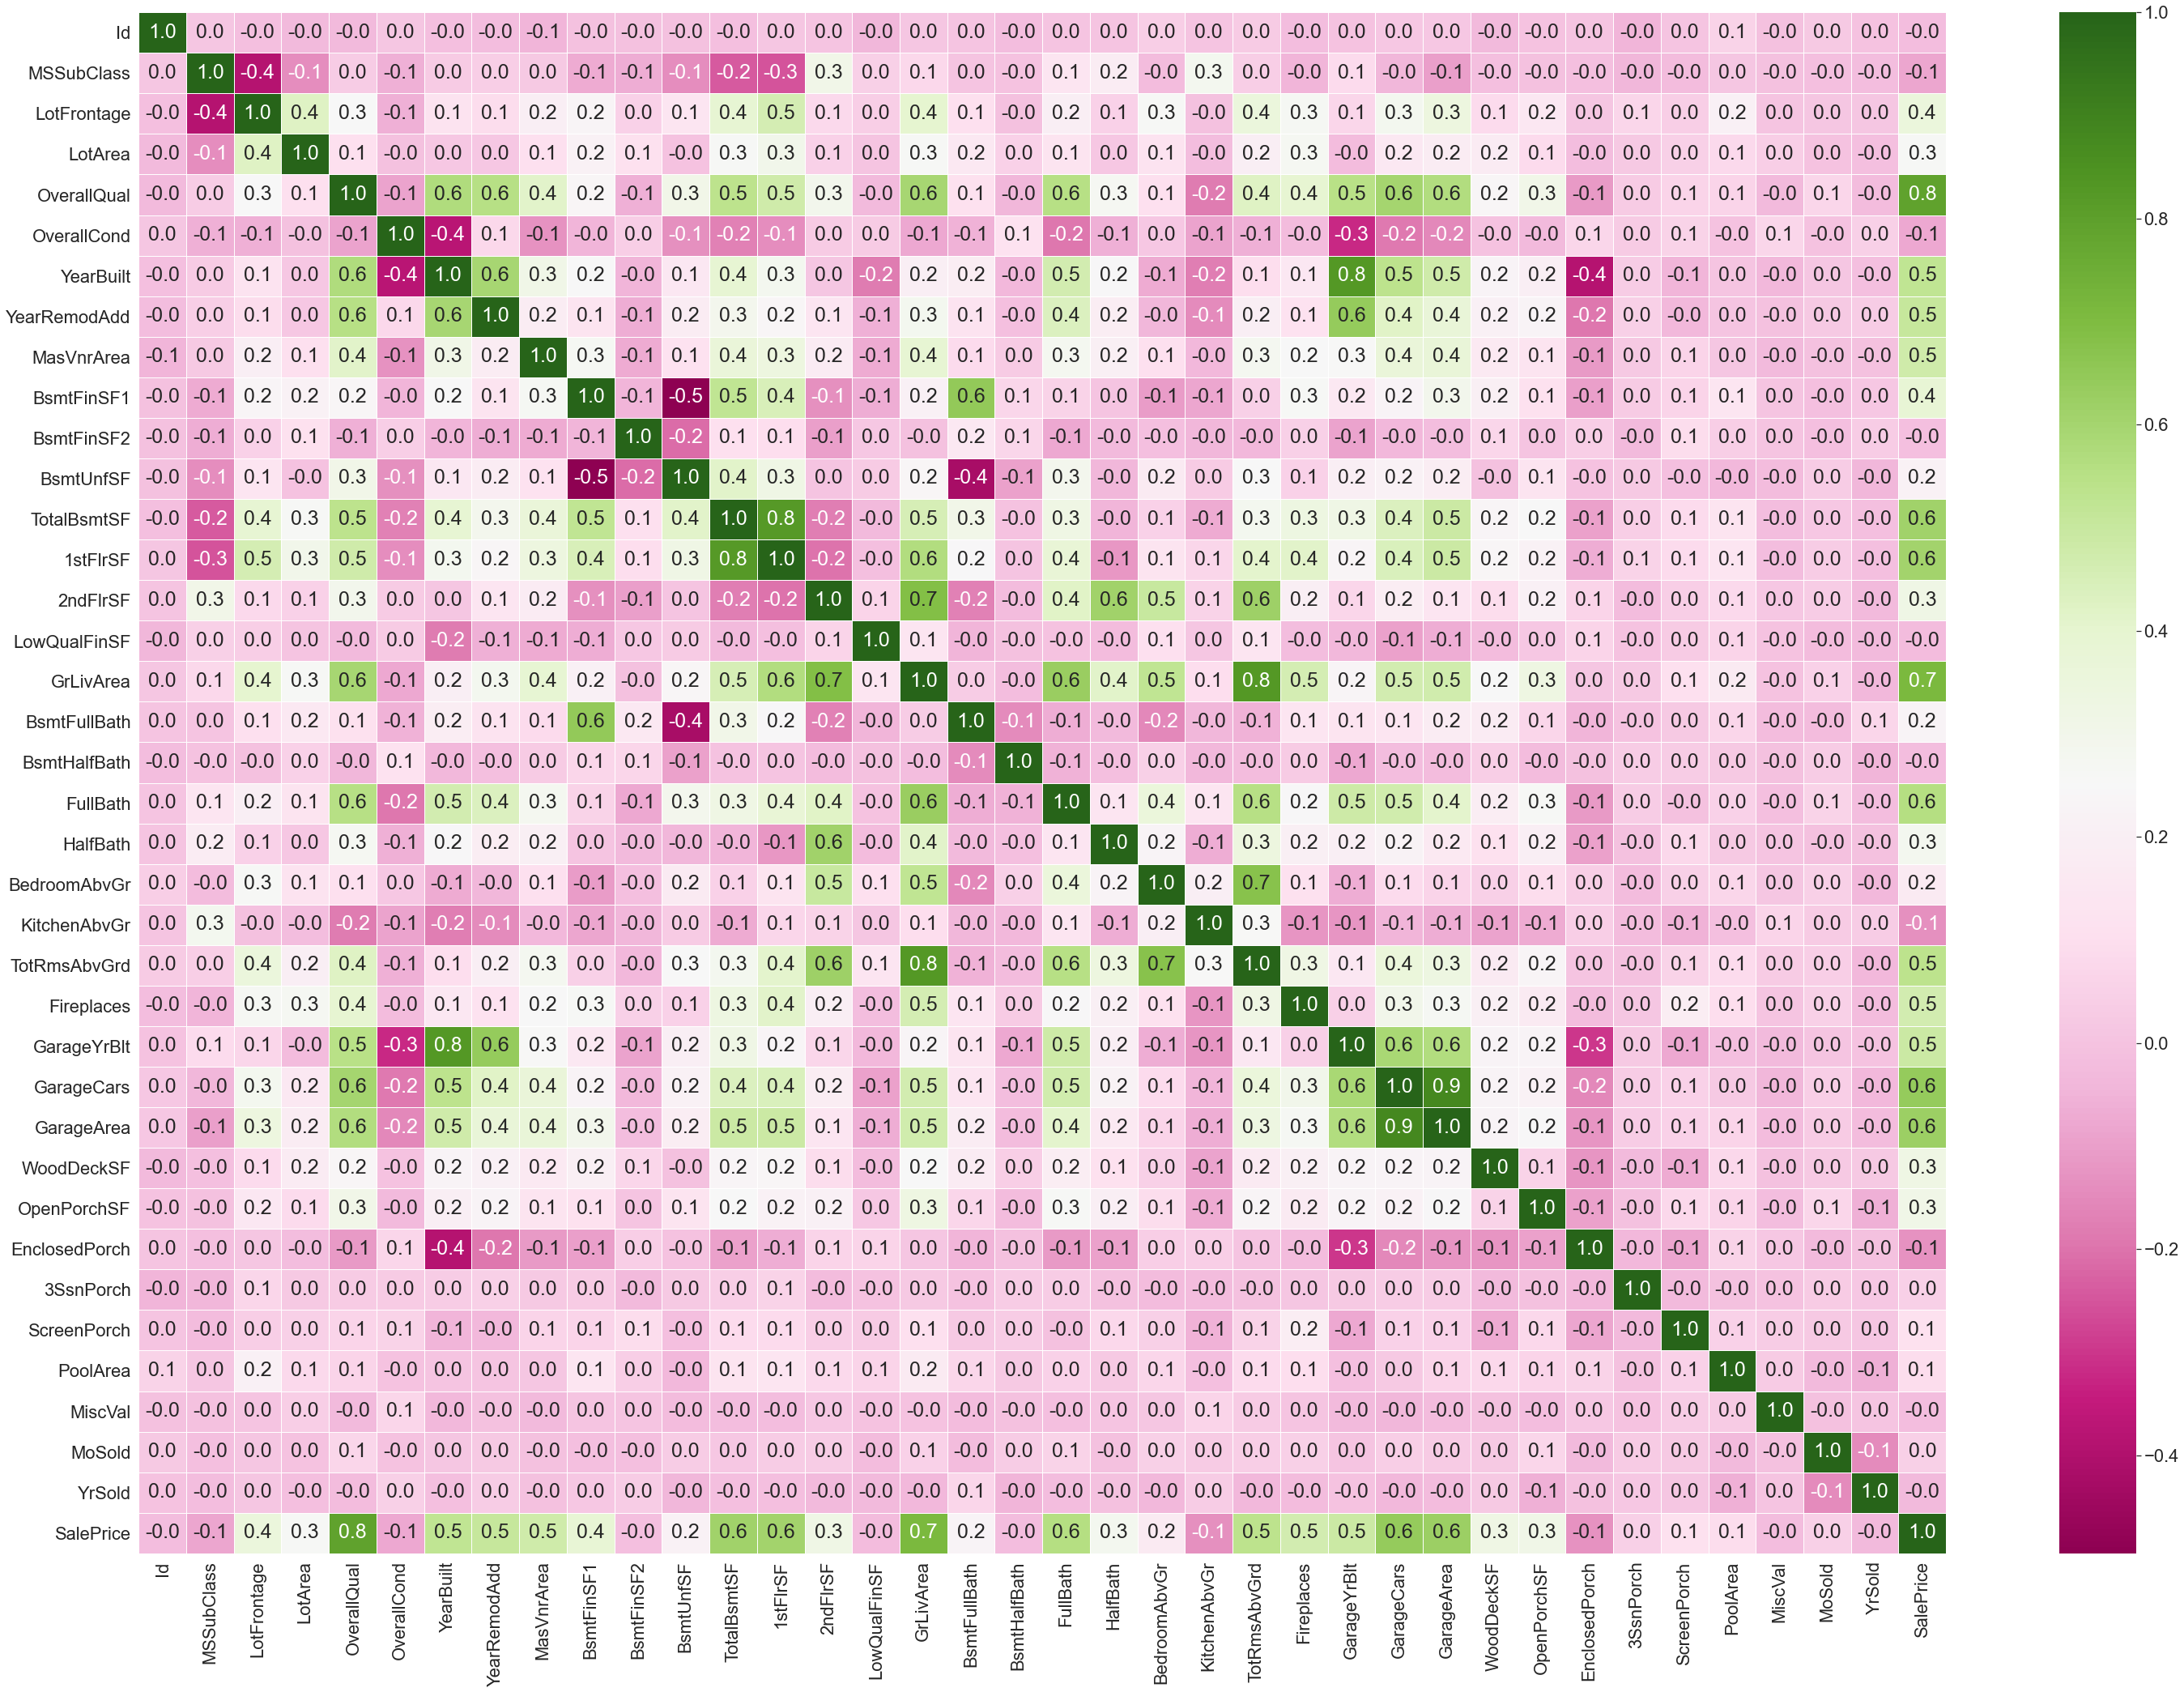

In [4]:
# color is terrible, must change!!!!!
correlation_train = train.corr()
sb.set(font_scale = 2)
plt.figure(figsize=(50,35))
ax = sb.heatmap(correlation_train, annot=True,annot_kws={"size": 25}
                ,fmt='.1f',cmap='PiYG', linewidths=.5)

In [5]:
correlation_train.columns

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice'],
      dtype='object')

In [6]:
corr_dict = correlation_train['SalePrice'].sort_values(ascending=False).to_dict()

important_columns = []

for key, value in corr_dict.items():
    if((value>0.1)&(value<0.8))|(value<=0.1):
        important_columns.append(key)

important_columns

['OverallQual',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'GarageYrBlt',
 'MasVnrArea',
 'Fireplaces',
 'BsmtFinSF1',
 'LotFrontage',
 'WoodDeckSF',
 '2ndFlrSF',
 'OpenPorchSF',
 'HalfBath',
 'LotArea',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BedroomAbvGr',
 'ScreenPorch',
 'PoolArea',
 'MoSold',
 '3SsnPorch',
 'BsmtFinSF2',
 'BsmtHalfBath',
 'MiscVal',
 'Id',
 'LowQualFinSF',
 'YrSold',
 'OverallCond',
 'MSSubClass',
 'EnclosedPorch',
 'KitchenAbvGr']

### In the visualization above, we can see the variables that affect SalePrice

<Figure size 2880x1440 with 0 Axes>

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111]),
 [Text(0, 0, '1872'),
  Text(1, 0, '1875'),
  Text(2, 0, '1880'),
  Text(3, 0, '1882'),
  Text(4, 0, '1885'),
  Text(5, 0, '1890'),
  Text(6, 0, '1892'),
  Text(7, 0, '1893'),
  Text(8, 0, '1898'),
  Text(9, 0, '1900'),
  Text(10, 0, '1904'),
  Text(11, 0, '1905'),
  Text(12, 0, '1906'),
  Text(13, 0, '1908'),
  Text(14, 0, '1910'),
  Text(15, 0, '1911'),
  Text(1

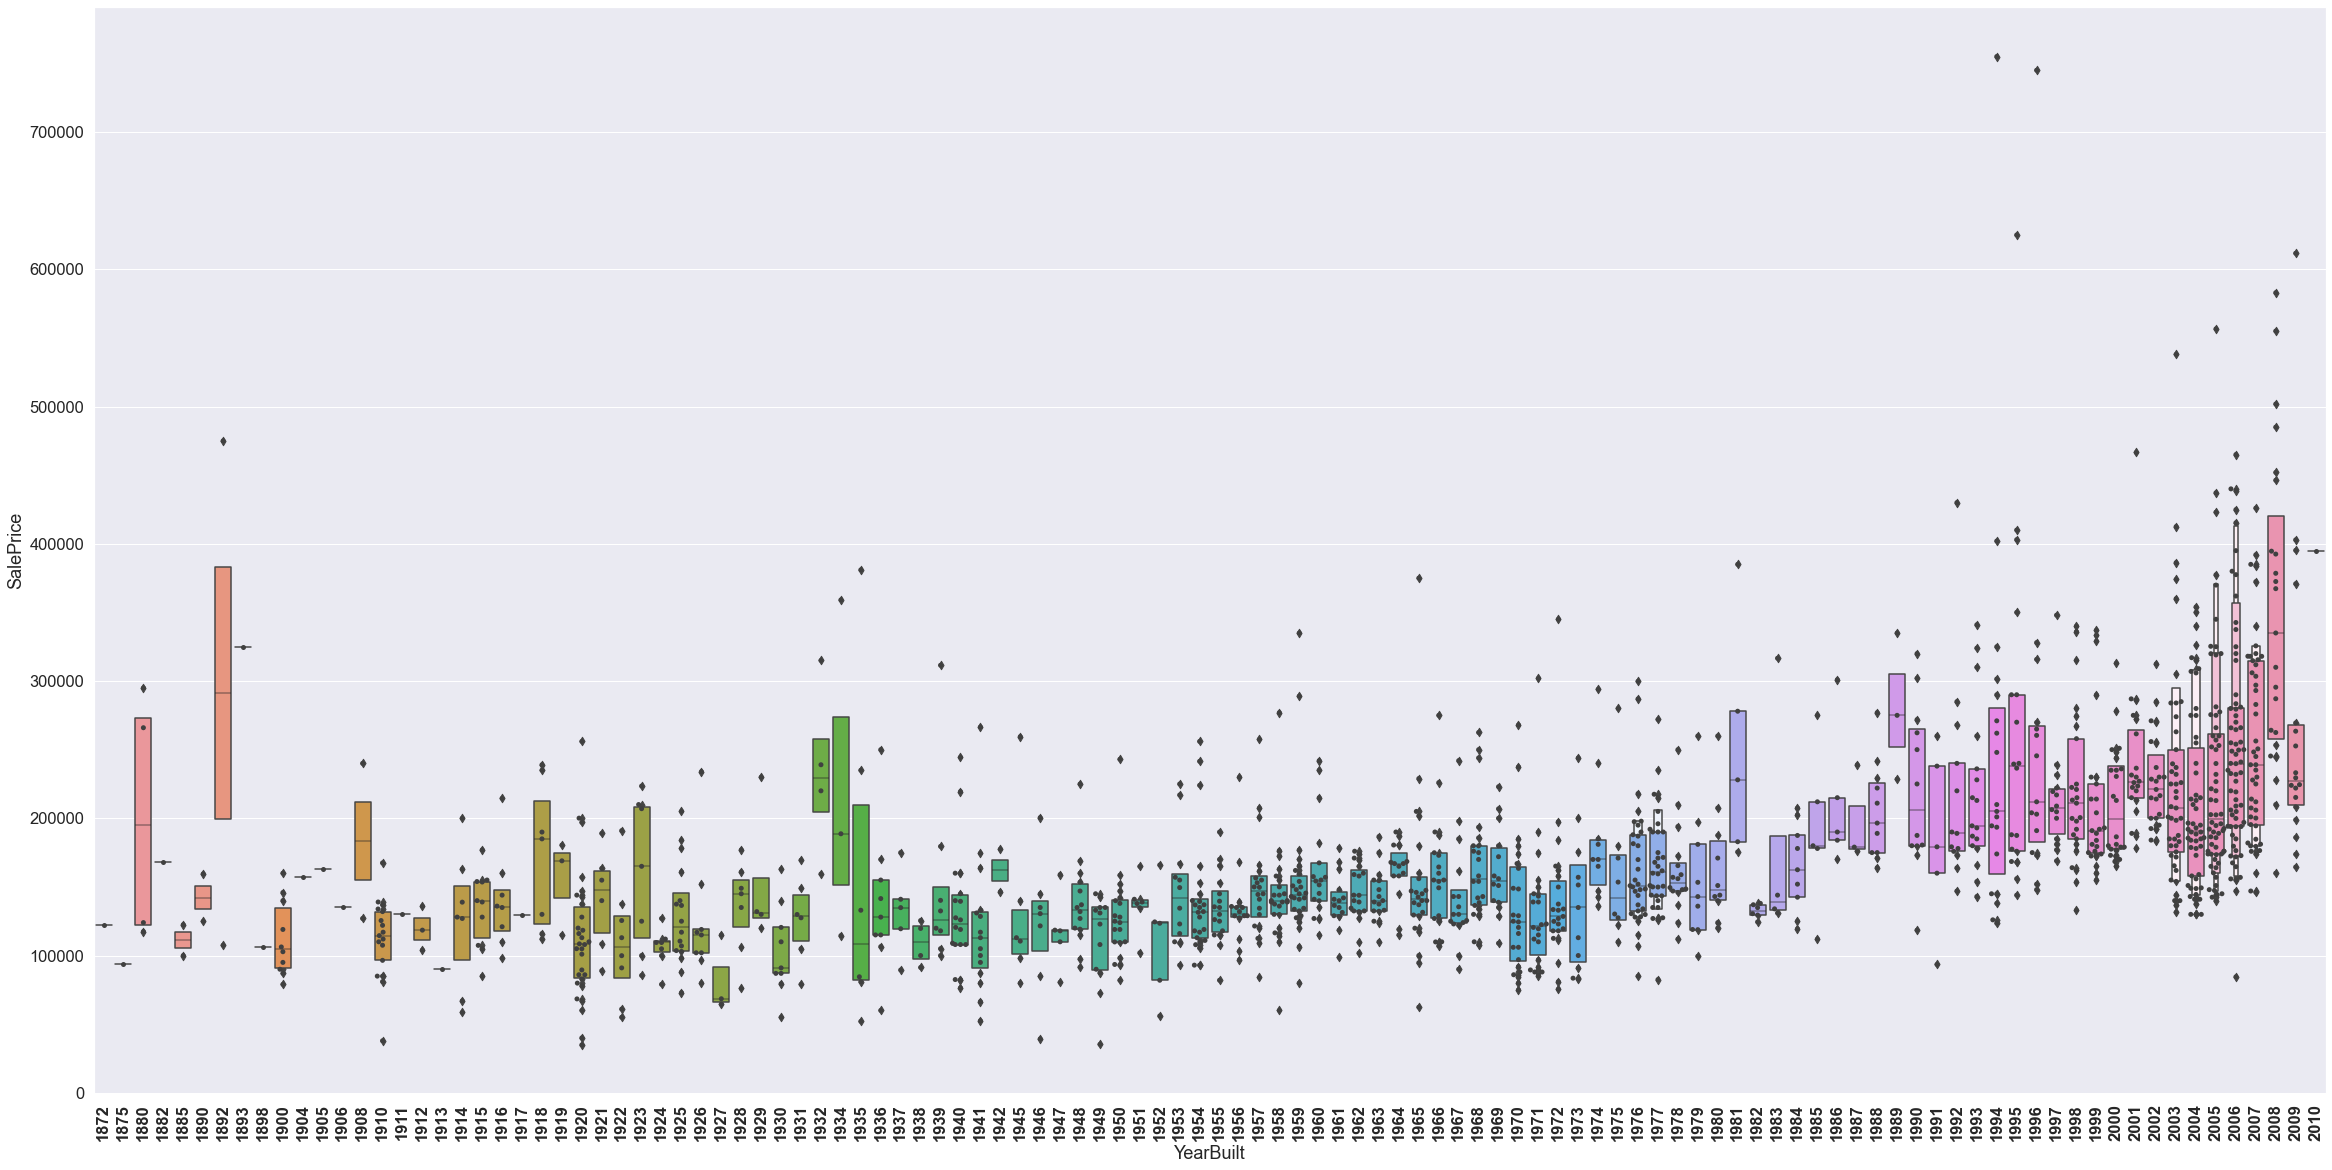

In [7]:
plt.figure(figsize=(40, 20))
sb.set(font_scale=1.5)
sb.boxenplot(x = 'YearBuilt', y = 'SalePrice', data = train)
sb.swarmplot(x = 'YearBuilt', y = 'SalePrice', data = train, color = '0.25')

plt.xticks(weight = 'bold', rotation = 90)

### We will predict SalePrice column

In [8]:
test.head()
test.info()
test.describe()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0  1461          20       RH         80.0    11622   Pave   NaN      Reg   
1  1462          20       RL         81.0    14267   Pave   NaN      IR1   
2  1463          60       RL         74.0    13830   Pave   NaN      IR1   
3  1464          60       RL         78.0     9978   Pave   NaN      IR1   
4  1465         120       RL         43.0     5005   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl        NAmes      Feedr   
1         Lvl    AllPub    Corner       Gtl        NAmes       Norm   
2         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
3         Lvl    AllPub    Inside       Gtl      Gilbert       Norm   
4         HLS    AllPub    Inside       Gtl      StoneBr       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     1Story            5            6       1961   
1       Norm     1Fam     1Story            6            6       1958   
2       Norm     1Fam     2Story            5            5       1997   
3       Norm     1Fam     2Story            6            6       1998   
4       Norm   TwnhsE     1Story            8            5       1992   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          1961     Gable  CompShg     VinylSd     VinylSd       None   
1          1958       Hip  CompShg     Wd Sdng     Wd Sdng    BrkFace   
2          1998     Gable  CompShg     VinylSd     VinylSd       None   
3          1998     Gable  CompShg     VinylSd     VinylSd    BrkFace   
4          1992     Gable  CompShg     HdBoard     HdBoard       None   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0         0.0        TA        TA     CBlock       TA       TA           No   
1       108.0        TA        TA     CBlock       TA       TA           No   
2         0.0        TA        TA      PConc       Gd       TA           No   
3        20.0        TA        TA      PConc       TA       TA           No   
4         0.0        Gd        TA      PConc       Gd       TA           No   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          Rec       468.0          LwQ       144.0      270.0        882.0   
1          ALQ       923.0          Unf         0.0      406.0       1329.0   
2          GLQ       791.0          Unf         0.0      137.0        928.0   
3          GLQ       602.0          Unf         0.0      324.0        926.0   
4          ALQ       263.0          Unf         0.0     1017.0       1280.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        TA          Y      SBrkr       896         0             0   
1    GasA        TA          Y      SBrkr      1329         0             0   
2    GasA        Gd          Y      SBrkr       928       701             0   
3    GasA        Ex          Y      SBrkr       926       678             0   
4    GasA        Ex          Y      SBrkr      1280         0             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0        896           0.0           0.0         1         0             2   
1       1329           0.0           0.0         1         1             3   
2       1629           0.0           0.0         2         1             3   
3       1604           0.0           0.0         2         1             3   
4       1280           0.0           0.0         2         0             2   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          TA             5        Typ           0         NaN   
1             1          Gd             6        Typ           0         NaN   
2             1          TA             6        Typ           1          TA   
3             1          Gd  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

Id   MSSubClass  LotFrontage       LotArea  OverallQual  \
count  1459.000000  1459.000000  1232.000000   1459.000000  1459.000000   
mean   2190.000000    57.378341    68.580357   9819.161069     6.078821   
std     421.321334    42.746880    22.376841   4955.517327     1.436812   
min    1461.000000    20.000000    21.000000   1470.000000     1.000000   
25%    1825.500000    20.000000    58.000000   7391.000000     5.000000   
50%    2190.000000    50.000000    67.000000   9399.000000     6.000000   
75%    2554.500000    70.000000    80.000000  11517.500000     7.000000   
max    2919.000000   190.000000   200.000000  56600.000000    10.000000   

       OverallCond    YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1  \
count  1459.000000  1459.000000   1459.000000  1444.000000  1458.000000   
mean      5.553804  1971.357779   1983.662783   100.709141   439.203704   
std       1.113740    30.390071     21.130467   177.625900   455.268042   
min       1.000000  1879.000000   1950.000000     0.000000     0.000000   
25%       5.000000  1953.000000   1963.000000     0.000000     0.000000   
50%       5.000000  1973.000000   1992.000000     0.000000   350.500000   
75%       6.000000  2001.000000   2004.000000   164.000000   753.500000   
max       9.000000  2010.000000   2010.000000  1290.000000  4010.000000   

        BsmtFinSF2    BsmtUnfSF  TotalBsmtSF     1stFlrSF     2ndFlrSF  \
count  1458.000000  1458.000000  1458.000000  1459.000000  1459.000000   
mean     52.619342   554.294925  1046.117970  1156.534613   325.967786   
std     176.753926   437.260486   442.898624   398.165820   420.610226   
min       0.000000     0.000000     0.000000   407.000000     0.000000   
25%       0.000000   219.250000   784.000000   873.500000     0.000000   
50%       0.000000   460.000000   988.000000  1079.000000     0.000000   
75%       0.000000   797.750000  1305.000000  1382.500000   676.000000   
max    1526.000000  2140.000000  5095.000000  5095.000000  1862.000000   

       LowQualFinSF    GrLivArea  BsmtFullBath  BsmtHalfBath     FullBath  \
count   1459.000000  1459.000000   1457.000000   1457.000000  1459.000000   
mean       3.543523  1486.045922      0.434454      0.065202     1.570939   
std       44.043251   485.566099      0.530648      0.252468     0.555190   
min        0.000000   407.000000      0.000000      0.000000     0.000000   
25%        0.000000  1117.500000      0.000000      0.000000     1.000000   
50%        0.000000  1432.000000      0.000000      0.000000     2.000000   
75%        0.000000  1721.000000      1.000000      0.000000     2.000000   
max     1064.000000  5095.000000      3.000000      2.000000     4.000000   

          HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
count  1459.000000   1459.000000   1459.000000   1459.000000  1459.00000   
mean      0.377656      2.854010      1.042495      6.385195     0.58122   
std       0.503017      0.829788      0.208472      1.508895     0.64742   
min       0.000000      0.000000      0.000000      3.000000     0.00000   
25%       0.000000      2.000000      1.000000      5.000000     0.00000   
50%       0.000000      3.000000      1.000000      6.000000     0.00000   
75%       1.000000      3.000000      1.000000      7.000000     1.00000   
max       2.000000      6.000000      2.000000     15.000000     4.00000   

       GarageYrBlt   GarageCars   GarageArea   WoodDeckSF  OpenPorchSF  \
count  1381.000000  1458.000000  1458.000000  1459.000000  1459.000000   
mean   1977.721217     1.766118   472.768861    93.174777    48.313914   
std      26.431175     0.775945   217.048611   127.744882    68.883364   
min    1895.000000     0.000000     0.000000     0.000000     0.000000   
25%    1959.000000     1.000000   318.000000     0.000000     0.000000   
50%    1979.000000     2.000000   480.000000     0.000000    28.000000   
75%    2002.000000     2.000000   576.000000   168.000000    72.000000   
max    2207.000000     5.0

## Clean and Edit Dataframes

### We must combine train and test datasets. Because this processes are must be carried out togerther.

In [9]:
train_test = pd.concat([train, test], axis = 0, sort = False)
train_test.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd       None   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng       None   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ       706.0          Unf         0.0      150.0        856.0   
1          ALQ       978.0          Unf         0.0      284.0       1262.0   
2          GLQ       486.0          Unf         0.0      434.0        920.0   
3          ALQ       216.0          Unf         0.0      540.0        756.0   
4          GLQ       655.0          Unf         0.0      490.0       1145.0   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710           1.0           0.0         2         1             3   
1       1262           0.0           1.0         2         0             3   
2       1786           1.0           0.0         2         1             3   
3       1717           1.0           0.0         1         0             3   
4       2198           1.0           0.0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

In [10]:
pd.set_option('display.max_rows', 5000)
train_test_null_info = pd.DataFrame(train_test.isnull().sum(), columns = ['Count of NaN'])
train_test_dtype_info = pd.DataFrame(train_test.dtypes, columns=['DataType'])
train_test_info = pd.concat([train_test_null_info, train_test_dtype_info], axis=1)

train_test_info

Count of NaN DataType
Id                        0    int64
MSSubClass                0    int64
MSZoning                  4   object
LotFrontage             486  float64
LotArea                   0    int64
Street                    0   object
Alley                  2721   object
LotShape                  0   object
LandContour               0   object
Utilities                 2   object
LotConfig                 0   object
LandSlope                 0   object
Neighborhood              0   object
Condition1                0   object
Condition2                0   object
BldgType                  0   object
HouseStyle                0   object
OverallQual               0    int64
OverallCond               0    int64
YearBuilt                 0    int64
YearRemodAdd              0    int64
RoofStyle                 0   object
RoofMatl                  0   object
Exterior1st               1   object
Exterior2nd               1   object
MasVnrType               24   object
MasVnrArea               23  float64
ExterQual                 0   object
ExterCond                 0   object
Foundation                0   object
BsmtQual                 81   object
BsmtCond                 82   object
BsmtExposure             82   object
BsmtFinType1             79   object
BsmtFinSF1                1  float64
BsmtFinType2             80   object
BsmtFinSF2                1  float64
BsmtUnfSF                 1  float64
TotalBsmtSF               1  float64
Heating                   0   object
HeatingQC                 0   object
CentralAir                0   object
Electrical                1   object
1stFlrSF                  0    int64
2ndFlrSF                  0    int64
LowQualFinSF              0    int64
GrLivArea                 0    int64
BsmtFullBath              2  float64
BsmtHalfBath              2  float64
FullBath                  0    int64
HalfBath                  0    int64
BedroomAbvGr              0    int64
KitchenAbvGr              0    int64
KitchenQual               1   object
TotRmsAbvGrd              0    int64
Functional                2   object
Fireplaces                0    int64
FireplaceQu            1420   object
GarageType              157   object
GarageYrBlt             159  float64
GarageFinish            159   object
GarageCars                1  float64
GarageArea                1  float64
GarageQual              159   object
GarageCond              159   object
PavedDrive                0   object
WoodDeckSF                0    int64
OpenPorchSF               0    int64
EnclosedPorch             0    int64
3SsnPorch                 0    int64
ScreenPorch               0    int64
PoolArea                  0    int64
PoolQC                 2909   object
Fence                  2348   object
MiscFeature            2814   object
MiscVal                   0    int64
MoSold                    0    int64
YrSold                    0    int64
SaleType                  1   object
SaleCondition             0   object
SalePrice              1459  float64

### Fillna and Feature Engineering

In [11]:
train_test.loc[train_test['Fireplaces']==0, 'FireplaceQu'] = 'Nothing'
train_test['LotFrontage'] = train_test['LotFrontage'].fillna(train_test.groupby('1stFlrSF')['LotFrontage'].transform('mean'))
train_test['LotFrontage'].interpolate(method = 'linear', inplace = True)
train_test['LotFrontage'] = train_test['LotFrontage'].astype(int)
train_test['MasVnrArea'] = train_test['MasVnrArea'].fillna(train_test.groupby('MasVnrType')['MasVnrArea'].transform('mean'))
train_test['MasVnrArea'].interpolate(method = 'linear', inplace = True)
train_test['MasVnrArea'] = train_test['MasVnrArea'].astype(int)
train_test['Fence'] = train_test['Fence'].fillna('None')
train_test['FireplaceQu'] = train_test['FireplaceQu'].fillna('None')
train_test['Alley'] = train_test['Alley'].fillna('None')
train_test['PoolQC'] = train_test['PoolQC'].fillna('None')
train_test['MiscFeature'] = train_test['MiscFeature'].fillna('None')
train_test.loc[train_test['BsmtFinSF1'] == 0, 'BsmtFinType1'] = 'Unf'
train_test.loc[train_test['BsmtFinSF2'] == 0, 'BsmtQual'] = 'TA'
train_test['YrBltRmd']=train_test['YearBuilt']+train_test['YearRemodAdd']
train_test['Total_Square_Feet'] = (train_test['BsmtFinSF1'] + train_test['BsmtFinSF2'] + train_test['1stFlrSF'] + train_test['2ndFlrSF'] + train_test['TotalBsmtSF'])
train_test['Total_Bath'] = (train_test['FullBath'] + (0.5 * train_test['HalfBath']) + train_test['BsmtFullBath'] + (0.5 * train_test['BsmtHalfBath']))
train_test['Total_Porch_Area'] = (train_test['OpenPorchSF'] + train_test['3SsnPorch'] + train_test['EnclosedPorch'] + train_test['ScreenPorch'] + train_test['WoodDeckSF'])
train_test['exists_pool'] = train_test['PoolArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_garage'] = train_test['GarageArea'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_fireplace'] = train_test['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)
train_test['exists_bsmt'] = train_test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
train_test['old_house'] = train_test['YearBuilt'].apply(lambda x: 1 if x <1990 else 0)

for i in train_test.columns:
    if 'SlaePrice' not in i:
        if 'object' in str(train_test[str(i)].dtype):
            train_test[str(i)] = train_test[str(i)].fillna(method = 'ffill')

In [12]:
columns = ('FireplaceQu', 'BsmtQual', 'BsmtCond', 'GarageQual', 'GarageCond', 'ExterQual', 'ExterCond','HeatingQC', 'PoolQC', 'KitchenQual', 'BsmtFinType1', 'YrSold', 'MoSold', 'BsmtFinType2', 'Functional', 'Fence', 'BsmtExposure', 'GarageFinish', 'LandSlope', 'LotShape', 'PavedDrive', 'Street', 'Alley', 'CentralAir', 'MSSubClass', 'OverallCond')

for col in columns:
    lbl_enc = LabelEncoder() 
    lbl_enc.fit(list(train_test[col].values)) 
    train_test[col] = lbl_enc.transform(list(train_test[col].values))

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

LabelEncoder()

In [13]:
numeric_features = train_test.dtypes[train_test.dtypes != "object"].index
skewed_features = train_test[numeric_features].apply(lambda x: skew(x)).sort_values(ascending=False)
print(skewed_features)

MiscVal              21.947195
PoolArea             16.898328
exists_pool          14.884318
LotArea              12.822431
LowQualFinSF         12.088761
3SsnPorch            11.376065
LandSlope             4.975157
KitchenAbvGr          4.302254
EnclosedPorch         4.003891
ScreenPorch           3.946694
MasVnrArea            2.600375
OpenPorchSF           2.535114
WoodDeckSF            1.842433
LotFrontage           1.483631
1stFlrSF              1.469604
Total_Porch_Area      1.376649
GrLivArea             1.269358
2ndFlrSF              0.861675
TotRmsAbvGrd          0.758367
MSSubClass            0.738722
Fireplaces            0.733495
HalfBath              0.694566
OverallCond           0.570312
HeatingQC             0.486656
FireplaceQu           0.333787
BedroomAbvGr          0.326324
OverallQual           0.197110
MoSold                0.195884
FullBath              0.167606
YrSold                0.132399
Id                    0.000000
exists_fireplace     -0.054148
BsmtFinT

In [14]:
high_skewness = skewed_features[abs(skewed_features) > 0.9]
skewed_features = high_skewness.index

In [15]:
high_skewness
skewed_features

MiscVal             21.947195
PoolArea            16.898328
exists_pool         14.884318
LotArea             12.822431
LowQualFinSF        12.088761
3SsnPorch           11.376065
LandSlope            4.975157
KitchenAbvGr         4.302254
EnclosedPorch        4.003891
ScreenPorch          3.946694
MasVnrArea           2.600375
OpenPorchSF          2.535114
WoodDeckSF           1.842433
LotFrontage          1.483631
1stFlrSF             1.469604
Total_Porch_Area     1.376649
GrLivArea            1.269358
BsmtExposure        -1.176341
KitchenQual         -1.448023
ExterQual           -1.801409
Fence               -1.993777
ExterCond           -2.497719
PavedDrive          -2.979084
BsmtCond            -3.301446
BsmtFinType2        -3.412861
CentralAir          -3.459022
GarageQual          -3.919880
exists_garage       -3.941054
Functional          -4.055757
GarageCond          -5.147262
exists_bsmt         -5.828995
BsmtQual            -6.303596
Street             -15.500133
PoolQC    

Index(['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF',
       '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage',
       '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive',
       'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street',
       'PoolQC'],
      dtype='object')

In [16]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

MiscVal  PoolArea  exists_pool  LotArea  LowQualFinSF  3SsnPorch  \
0        0         0            0     8450             0          0   
1        0         0            0     9600             0          0   
2        0         0            0    11250             0          0   
3        0         0            0     9550             0          0   
4        0         0            0    14260             0          0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  MasVnrArea  \
0          0             1              0            0         196   
1          0             1              0            0           0   
2          0             1              0            0         162   
3          0             1            272            0           0   
4          0             1              0            0         350   

   OpenPorchSF  WoodDeckSF  LotFrontage  1stFlrSF  Total_Porch_Area  \
0           61           0           65       856                61   
1            0         298           80      1262               298   
2           42           0           68       920                42   
3           35           0           60       961               307   
4           84         192           84      1145               276   

   GrLivArea  BsmtExposure  KitchenQual  ExterQual  Fence  ExterCond  \
0       1710             3            2          2      4          4   
1       1262             1            3          3      4          4   
2       1786             2            2          2      4          4   
3       1717             3            2          3      4          4   
4       2198             0            2          2      4          4   

   PavedDrive  BsmtCond  BsmtFinType2  CentralAir  GarageQual  exists_garage  \
0           2         3             5           1           4              1   
1           2         3             5           1           4              1   
2           2         3             5           1           4              1   
3           2         1             5           1           4              1   
4           2         3             5           1           4              1   

   Functional  GarageCond  exists_bsmt  BsmtQual  Street  PoolQC  
0           6           4            1         3       1       3  
1           6           4            1         3       1       3  
2           6           4            1         3       1       3  
3           6           4            1         3       1       3  
4           6           4            1         3       1       3

In [17]:
for feature in skewed_features:
    train_test[feature] = boxcox1p(train_test[feature], boxcox_normmax(train_test[feature] + 1))

In [18]:
train_test[['MiscVal', 'PoolArea', 'exists_pool', 'LotArea', 'LowQualFinSF', '3SsnPorch', 'LandSlope', 'KitchenAbvGr', 'EnclosedPorch',
       'ScreenPorch', 'MasVnrArea', 'OpenPorchSF', 'WoodDeckSF', 'LotFrontage', '1stFlrSF', 'Total_Porch_Area', 'GrLivArea', 'BsmtExposure',
       'KitchenQual', 'ExterQual', 'Fence', 'ExterCond', 'PavedDrive', 'BsmtCond', 'BsmtFinType2', 'CentralAir', 'GarageQual', 'exists_garage',
       'Functional', 'GarageCond', 'exists_bsmt', 'BsmtQual', 'Street','PoolQC']].head()

MiscVal  PoolArea  exists_pool    LotArea  LowQualFinSF  3SsnPorch  \
0      0.0       0.0          0.0  13.424521           0.0        0.0   
1      0.0       0.0          0.0  13.694527           0.0        0.0   
2      0.0       0.0          0.0  14.034133           0.0        0.0   
3      0.0       0.0          0.0  13.683421           0.0        0.0   
4      0.0       0.0          0.0  14.550142           0.0        0.0   

   LandSlope  KitchenAbvGr  EnclosedPorch  ScreenPorch  MasVnrArea  \
0        0.0       0.75096       0.000000          0.0   19.509966   
1        0.0       0.75096       0.000000          0.0    0.000000   
2        0.0       0.75096       0.000000          0.0   17.835996   
3        0.0       0.75096      16.012025          0.0    0.000000   
4        0.0       0.75096       0.000000          0.0   25.518156   

   OpenPorchSF  WoodDeckSF  LotFrontage  1stFlrSF  Total_Porch_Area  \
0    12.009558    0.000000    13.668864  5.318378         18.721470   
1     0.000000   56.339208    15.311587  5.550626         51.575372   
2     9.849185    0.000000    14.011693  5.362015         14.644414   
3     8.921746    0.000000    13.079140  5.388291         52.547851   
4    14.180238   42.351292    15.722537  5.493031         49.148918   

   GrLivArea  BsmtExposure  KitchenQual  ExterQual     Fence  ExterCond  \
0   7.234115      6.112249     5.077704   5.498765  6.897404   5.100237   
1   6.947212      1.372290    10.302990  11.456357  6.897404   5.100237   
2   7.275132      3.429155     5.077704   5.498765  6.897404   5.100237   
3   7.237969      6.112249     5.077704  11.456357  6.897404   5.100237   
4   7.470741      0.000000     5.077704   5.498765  6.897404   5.100237   

   PavedDrive  BsmtCond  BsmtFinType2  CentralAir  GarageQual  exists_garage  \
0   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
1   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
2   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   
3   10.465804  1.280547   1444.255548   72.932968   23.440981       1.096819   
4   10.465804  5.218987   1444.255548   72.932968   23.440981       1.096819   

   Functional  GarageCond  exists_bsmt   BsmtQual    Street       PoolQC  
0   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
1   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
2   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
3   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981  
4   30.831053  2952.40927    41.797413  54.556642  1.965139  3975.432981

In [19]:
train_test = pd.get_dummies(train_test, dtype='int8')

In [20]:
train_test_null_info = pd.DataFrame(train_test.isnull().sum(), columns=['Count of NaN'])
train_test_dtype_info = pd.DataFrame(train_test.dtypes, columns=['DataTypes'])
train_test_info = pd.concat([train_test_null_info, train_test_dtype_info], axis = 1)
train_test_info

Count of NaN DataTypes
Id                                0     int64
MSSubClass                        0     int64
LotFrontage                       0   float64
LotArea                           0   float64
Street                            0   float64
Alley                             0     int64
LotShape                          0     int64
LandSlope                         0   float64
OverallQual                       0     int64
OverallCond                       0     int64
YearBuilt                         0     int64
YearRemodAdd                      0     int64
MasVnrArea                        0   float64
ExterQual                         0   float64
ExterCond                         0   float64
BsmtQual                          0   float64
BsmtCond                          0   float64
BsmtExposure                      0   float64
BsmtFinType1                      0     int64
BsmtFinSF1                        1   float64
BsmtFinType2                      0   float64
BsmtFinSF2                        1   float64
BsmtUnfSF                         1   float64
TotalBsmtSF                       1   float64
HeatingQC                         0     int64
CentralAir                        0   float64
1stFlrSF                          0   float64
2ndFlrSF                          0     int64
LowQualFinSF                      0   float64
GrLivArea                         0   float64
BsmtFullBath                      2   float64
BsmtHalfBath                      2   float64
FullBath                          0     int64
HalfBath                          0     int64
BedroomAbvGr                      0     int64
KitchenAbvGr                      0   float64
KitchenQual                       0   float64
TotRmsAbvGrd                      0     int64
Functional                        0   float64
Fireplaces                        0     int64
FireplaceQu                       0     int64
GarageYrBlt                     159   float64
GarageFinish                      0     int64
GarageCars                        1   float64
GarageArea                        1   float64
GarageQual                        0   float64
GarageCond                        0   float64
PavedDrive                        0   float64
WoodDeckSF                        0   float64
OpenPorchSF                       0   float64
EnclosedPorch                     0   float64
3SsnPorch                         0   float64
ScreenPorch                       0   float64
PoolArea                          0   float64
PoolQC                            0   float64
Fence                             0   float64
MiscVal                           0   float64
MoSold                            0     int64
YrSold                            0     int64
SalePrice                      1459   float64
YrBltRmd                          0     int64
Total_Square_Feet                 1   float64
Total_Bath                        2   float64
Total_Porch_Area                  0   float64
exists_pool                       0   float64
exists_garage                     0   float64
exists_fireplace                  0     int64
exists_bsmt                       0   float64
old_house                         0     int64
MSZoning_C (all)                  0      int8
MSZoning_FV                       0      int8
MSZoning_RH                       0      int8
MSZoning_RL                       0      int8
MSZoning_RM                       0      int8
LandContour_Bnk                   0      int8
LandContour_HLS                   0      int8
LandContour_Low                   0      int8
LandContour_Lvl                   0      int8
Utilities_AllPub                  0      int8
Utilities_NoSeWa                  0      int8
LotConfig_Corner                  0      int8
LotConfig_CulDSac                 0      int8
LotConfig_FR2                     0      int8
LotConfig_FR3                     0      int8
LotConfig_Inside                  0      int8
Neighborhood_Blmngtn              0      int8
Neighborhood_Blueste 

In [21]:
train = train_test[0:1460]
test = train_test[1460:2919]
len(train)

1460

In [22]:
train.interpolate(method='linear', inplace=True)
test.interpolate(method='linear', inplace=True)

<Figure size 360x1080 with 0 Axes>

<AxesSubplot:>

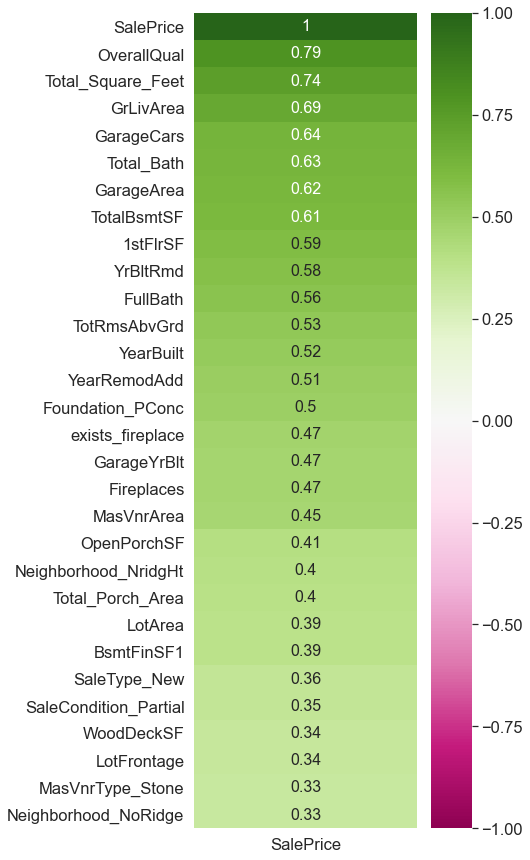

In [23]:
corr_new_train = train.corr()
plt.figure(figsize=(5, 15))
sb.heatmap(corr_new_train[['SalePrice']].sort_values(by = ['SalePrice'], ascending=False).head(30)
           , annot_kws={'size':16}, vmin = -1, cmap = 'PiYG', annot= True)

sb.set(font_scale = 2)

In [24]:
corr_dict2 = corr_new_train['SalePrice'].sort_values(ascending=False).to_dict()
corr_dict2

{'SalePrice': 1.0,
 'OverallQual': 0.7909816005838053,
 'Total_Square_Feet': 0.7378811939482359,
 'GrLivArea': 0.6948427961005592,
 'GarageCars': 0.6404091972583519,
 'Total_Bath': 0.631731067931988,
 'GarageArea': 0.6234314389183622,
 'TotalBsmtSF': 0.6135805515591943,
 '1stFlrSF': 0.5885261481098696,
 'YrBltRmd': 0.5761444313502826,
 'FullBath': 0.5606637627484453,
 'TotRmsAbvGrd': 0.5337231555820284,
 'YearBuilt': 0.5228973328794967,
 'YearRemodAdd': 0.5071009671113866,
 'Foundation_PConc': 0.4977337525869374,
 'exists_fireplace': 0.4719080685164944,
 'GarageYrBlt': 0.46729002276453935,
 'Fireplaces': 0.46692883675152763,
 'MasVnrArea': 0.454930796032295,
 'OpenPorchSF': 0.40653586942641723,
 'Neighborhood_NridgHt': 0.4021485981752677,
 'Total_Porch_Area': 0.39516894228291555,
 'LotArea': 0.3906209685629592,
 'BsmtFinSF1': 0.3864198062421535,
 'SaleType_New': 0.35750940508319323,
 'SaleCondition_Partial': 0.3520598546714349,
 'WoodDeckSF': 0.33765584830708145,
 'LotFrontage': 0.3370

In [25]:
best_columns = []
for key, value in corr_dict2.items():
    if ((value>=0.3175)&(value<0.9))|(value <= -0.315):
        best_columns.append(key)

best_columns
len(best_columns)

['OverallQual',
 'Total_Square_Feet',
 'GrLivArea',
 'GarageCars',
 'Total_Bath',
 'GarageArea',
 'TotalBsmtSF',
 '1stFlrSF',
 'YrBltRmd',
 'FullBath',
 'TotRmsAbvGrd',
 'YearBuilt',
 'YearRemodAdd',
 'Foundation_PConc',
 'exists_fireplace',
 'GarageYrBlt',
 'Fireplaces',
 'MasVnrArea',
 'OpenPorchSF',
 'Neighborhood_NridgHt',
 'Total_Porch_Area',
 'LotArea',
 'BsmtFinSF1',
 'SaleType_New',
 'SaleCondition_Partial',
 'WoodDeckSF',
 'LotFrontage',
 'MasVnrType_Stone',
 'Neighborhood_NoRidge',
 '2ndFlrSF',
 'Foundation_CBlock',
 'MasVnrType_None',
 'GarageType_Detchd',
 'HeatingQC',
 'GarageFinish',
 'old_house',
 'KitchenQual',
 'ExterQual']

38

<Figure size 1800x720 with 0 Axes>

<AxesSubplot:>

(array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
        35, 36, 37, 38]),
 [Text(1, 0, 'OverallQual'),
  Text(2, 0, 'Total_Square_Feet'),
  Text(3, 0, 'GrLivArea'),
  Text(4, 0, 'GarageCars'),
  Text(5, 0, 'Total_Bath'),
  Text(6, 0, 'GarageArea'),
  Text(7, 0, 'TotalBsmtSF'),
  Text(8, 0, '1stFlrSF'),
  Text(9, 0, 'YrBltRmd'),
  Text(10, 0, 'FullBath'),
  Text(11, 0, 'TotRmsAbvGrd'),
  Text(12, 0, 'YearBuilt'),
  Text(13, 0, 'YearRemodAdd'),
  Text(14, 0, 'Foundation_PConc'),
  Text(15, 0, 'exists_fireplace'),
  Text(16, 0, 'GarageYrBlt'),
  Text(17, 0, 'Fireplaces'),
  Text(18, 0, 'MasVnrArea'),
  Text(19, 0, 'OpenPorchSF'),
  Text(20, 0, 'Neighborhood_NridgHt'),
  Text(21, 0, 'Total_Porch_Area'),
  Text(22, 0, 'LotArea'),
  Text(23, 0, 'BsmtFinSF1'),
  Text(24, 0, 'SaleType_New'),
  Text(25, 0, 'SaleCondition_Partial'),
  Text(26, 0, 'WoodDeckSF'),
  Text(27, 0, 'LotFrontage'),
  

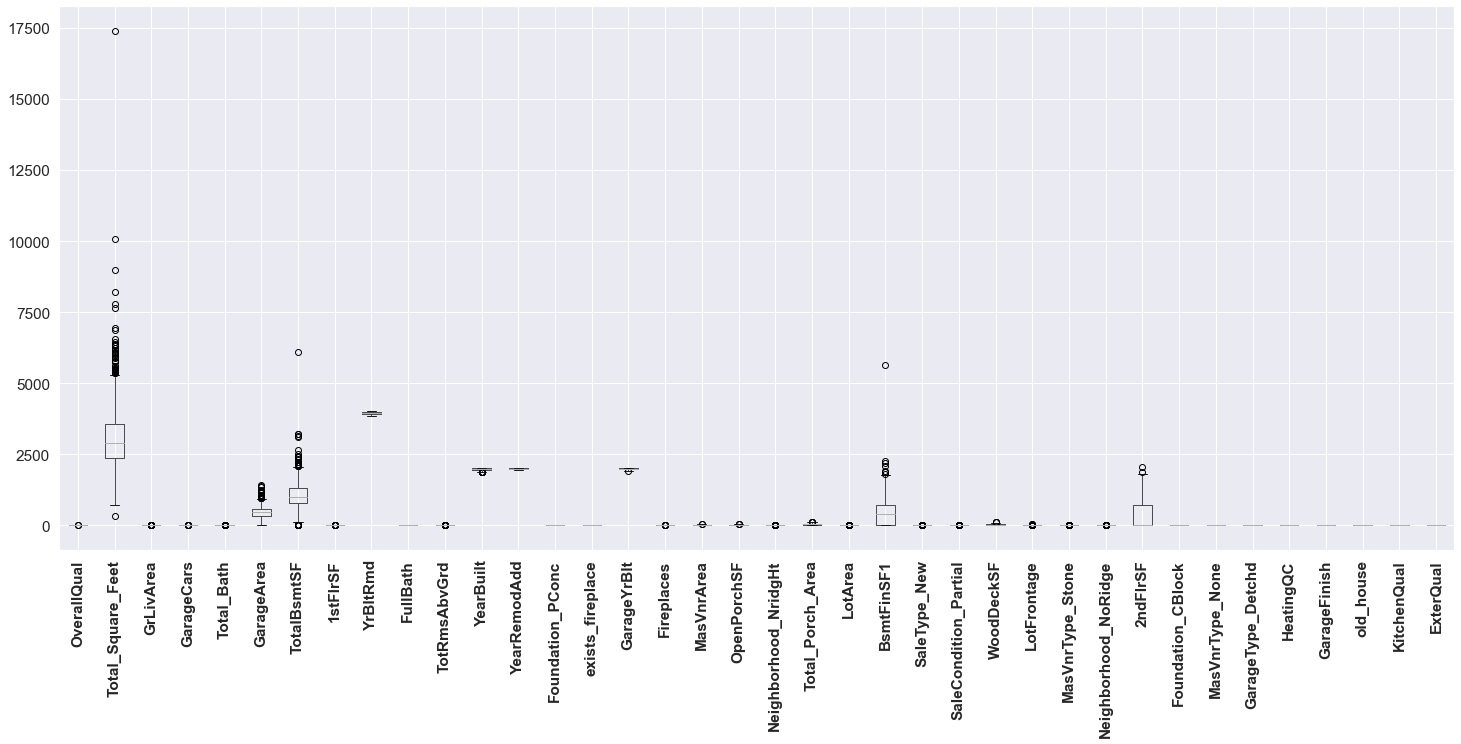

In [26]:
plt.figure(figsize=(25, 10))
sb.set(font_scale = 1.4)
train.boxplot(column=best_columns)
plt.xticks(weight = 'bold', rotation = 90)

In [27]:
train['SalePrice_Log1p'] = np.log1p(train.SalePrice)

train.head()
min(train['SalePrice_Log1p'])
max(train['SalePrice_Log1p'])

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
0   1           5    13.668864  13.424521  1.965139      1         3   
1   2           0    15.311587  13.694527  1.965139      1         3   
2   3           5    14.011693  14.034133  1.965139      1         0   
3   4           6    13.079140  13.683421  1.965139      1         0   
4   5           5    15.722537  14.550142  1.965139      1         0   

   LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0        0.0            7            4       2003          2003   19.509966   
1        0.0            6            7       1976          1976    0.000000   
2        0.0            7            4       2001          2002   17.835996   
3        0.0            7            4       1915          1970    0.000000   
4        0.0            8            4       2000          2000   25.518156   

   ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0   5.498765   5.100237  54.556642  5.218987      6.112249             2   
1  11.456357   5.100237  54.556642  5.218987      1.372290             0   
2   5.498765   5.100237  54.556642  5.218987      3.429155             2   
3  11.456357   5.100237  54.556642  1.280547      6.112249             0   
4   5.498765   5.100237  54.556642  5.218987      0.000000             2   

   BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0       706.0   1444.255548         0.0      150.0        856.0          0   
1       978.0   1444.255548         0.0      284.0       1262.0          0   
2       486.0   1444.255548         0.0      434.0        920.0          0   
3       216.0   1444.255548         0.0      540.0        756.0          2   
4       655.0   1444.255548         0.0      490.0       1145.0          0   

   CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0   72.932968  5.318378       854           0.0   7.234115           1.0   
1   72.932968  5.550626         0           0.0   6.947212           0.0   
2   72.932968  5.362015       866           0.0   7.275132           1.0   
3   72.932968  5.388291       756           0.0   7.237969           1.0   
4   72.932968  5.493031      1053           0.0   7.470741           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0         2         1             3       0.75096     5.077704   
1           1.0         2         0             3       0.75096    10.302990   
2           0.0         2         1             3       0.75096     5.077704   
3           0.0         1         0             3       0.75096     5.077704   
4           0.0         2         1             4       0.75096     5.077704   

   TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  \
0             8   30.831053           0            3       2003.0   
1             6   30.831053           1            5       1976.0   
2             6   30.831053           1            5       2001.0   
3             7   30.831053           1            2       1998.0   
4             9   30.831053           1            5       2000.0   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0             1         2.0       548.0   23.440981  2952.40927   10.465804   
1             1         2.0       460.0   23.440981  2952.40927   10.465804   
2             1         2.0       608.0   23.440981  2952.40927   10.465804   
3             2         3.0       642.0   23.440981  2952.40927   10.465804   
4             1         3.0       836.0   23.440981  2952.40927   10.465804   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0    0.000000    12.009558       0.000000        0.0          0.0       0.0   
1   56.339208     0.000000       0.000000        0.0          0.0       0.0   
2    0.000000     9.849185       0.000000        0.0          0.0       0.0   
3    0.000000     8.92174

10.460270761075149

13.534474352733596

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

Text(0.5, 0, 'SalePrice')

Skew Dist: 1.8828757597682129
Kurtosis Dist: 6.536281860064529


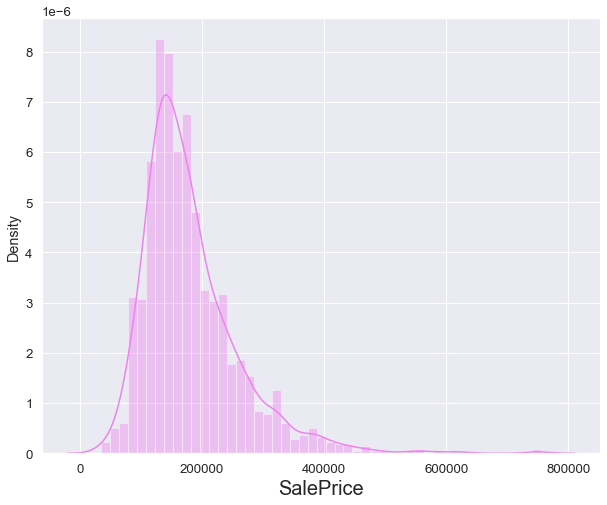

In [28]:
plt.figure(figsize=(10, 8))
sb.set(font_scale = 1.2)
sb.distplot(train['SalePrice'], color = 'violet')
plt.xlabel('SalePrice', fontsize = 20)
print('Skew Dist:', train['SalePrice'].skew())
print('Kurtosis Dist:', train['SalePrice'].kurt())

<Figure size 720x576 with 0 Axes>

<AxesSubplot:xlabel='SalePrice_Log1p', ylabel='Density'>

Text(0.5, 0, 'SalePrice_Log1p')

Skew Dist: 0.12134661989685329
Kurtosis Dist: 0.809519155707878


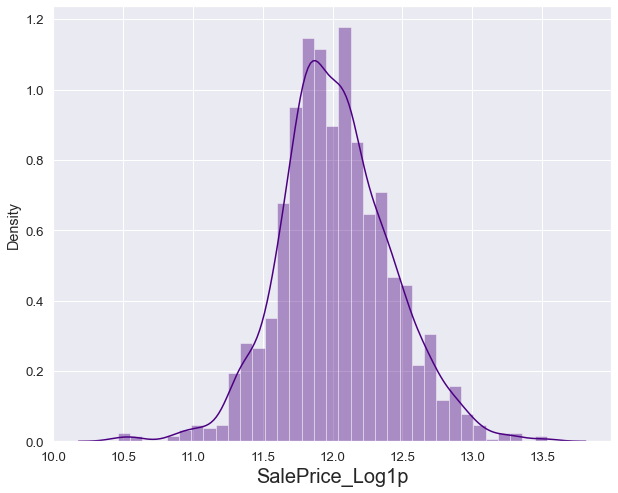

In [29]:
plt.figure(figsize=(10,8))
sb.set(font_scale=1.2)
sb.distplot(train['SalePrice_Log1p'],color='indigo')
plt.xlabel('SalePrice_Log1p',fontsize=20)
print('Skew Dist:',train['SalePrice_Log1p'].skew())
print('Kurtosis Dist:',train['SalePrice_Log1p'].kurt())

In [30]:
print(len(train[(train.KitchenQual == 3) & (train.SalePrice>360000)].index))

0


In [31]:
len(train)

1460

<Figure size 1440x864 with 0 Axes>

([<matplotlib.axis.XTick at 0x130a094f0>,
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

Text(0.5, 0, 'Number of components')

Text(0, 0.5, 'Explanined variance ratio for number of components')

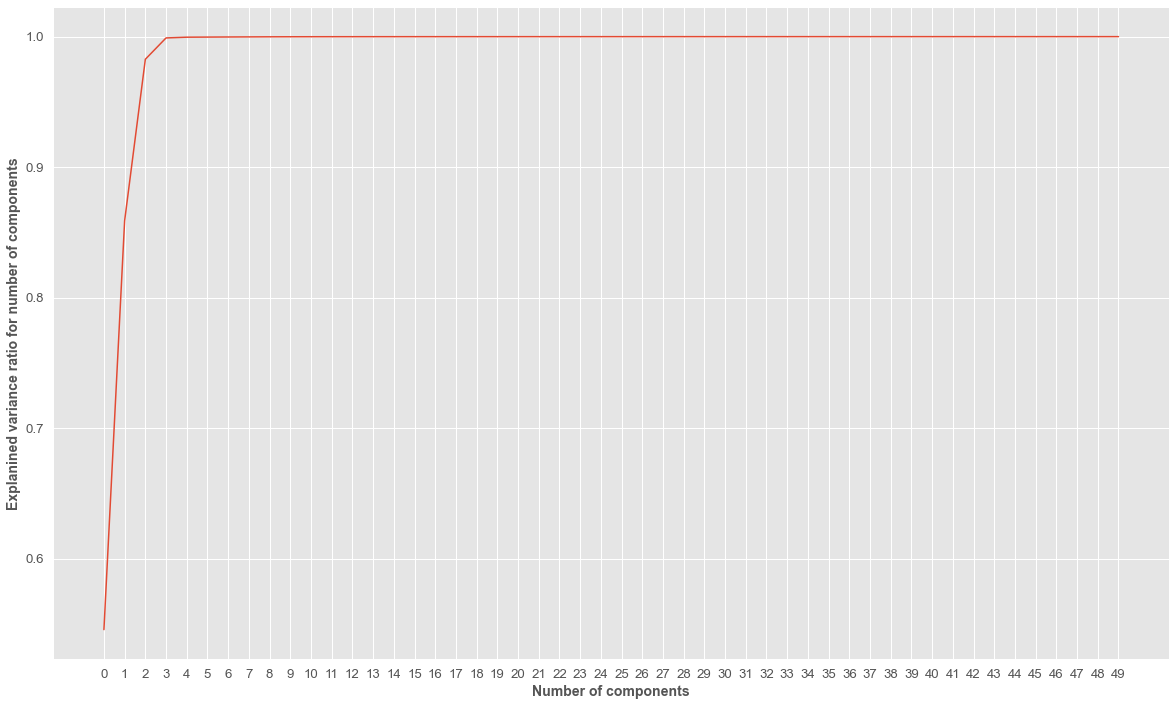

In [32]:
plt.style.use('ggplot')
plt.figure(figsize=(20, 12))
rbst_scaler = RobustScaler()
train_rbst = rbst_scaler.fit_transform(train)

pca=PCA(50).fit(train_rbst)
plt.plot(pca.explained_variance_ratio_.cumsum())
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of components', fontweight = 'bold', size = 14)
plt.ylabel('Explanined variance ratio for number of components', fontweight = 'bold', size = 14)

train_pca = PCA(3).fit_transform(train_rbst)

<Figure size 1080x1080 with 0 Axes>

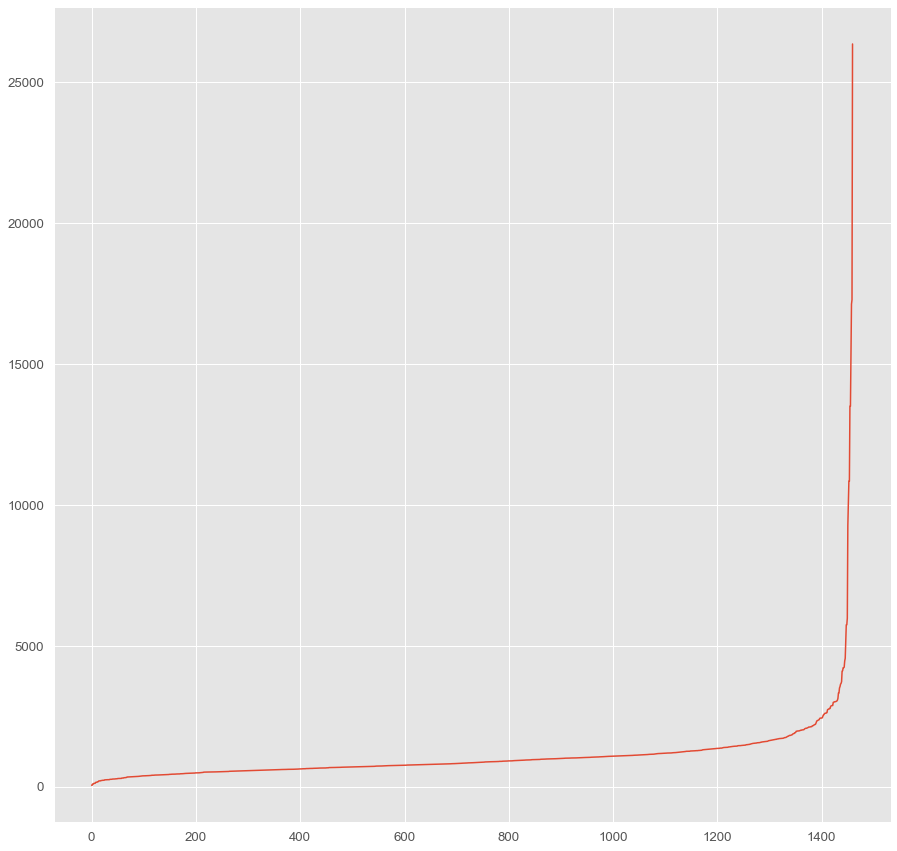

In [33]:
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(train)
distances, indices = nbrs.kneighbors(train)
distances = np.sort(distances, axis = 0)
distances = distances[:, 1]
plt.figure(figsize=(15, 15))
plt.plot(distances)

In [34]:
dbscan = DBSCAN(eps = 1400, min_samples=20).fit(train_pca)
core_samples_mask = np.zeros_like(dbscan.labels_, dtype = bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

<Figure size 864x864 with 0 Axes>

Text(0.5, 1.0, 'Estimated number of clusters: 2')

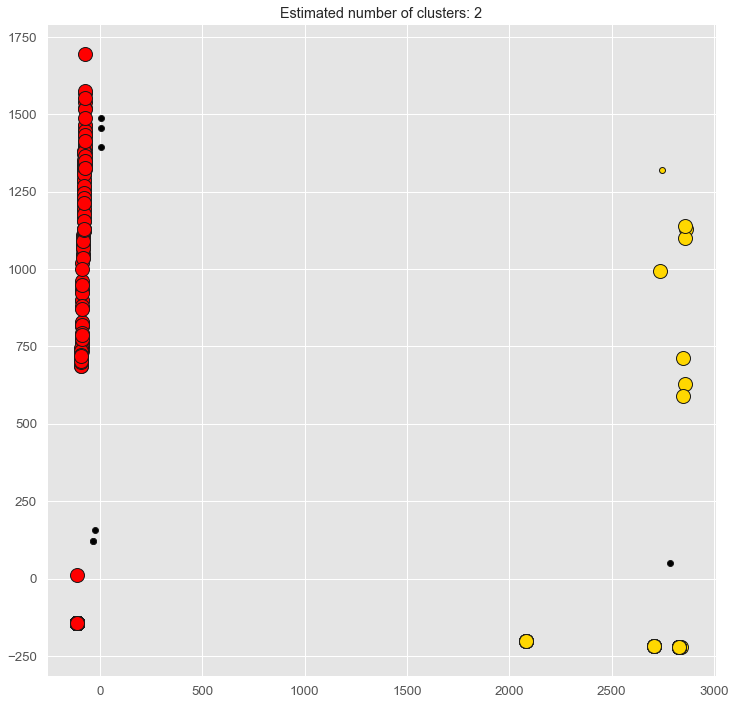

In [35]:
unique_labels = set(labels)
plt.figure(figsize=(12,12))
colors = [plt.cm.prism(each)  for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)
    
    xy = train_pca[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = train_pca[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [36]:
labels = pd.DataFrame(labels, columns=['Classes'])
print(labels[labels['Classes']== -1])

      Classes
197        -1
810        -1
1170       -1
1182       -1
1298       -1
1386       -1
1423       -1


In [37]:
train = pd.concat([train, labels], axis = 1)
train[train.Classes == -1]

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
197    198           7    23.181520  15.851262  1.965139      1         3   
810    811           0    15.102191  13.811203  1.965139      1         3   
1170  1171           8    14.890046  13.755757  1.965139      1         3   
1182  1183           5    22.181022  14.751522  1.965139      1         0   
1298  1299           5    31.456868  18.058231  1.965139      1         2   
1386  1387           5    15.311587  14.898480  1.965139      1         0   
1423  1424           8    14.457070  15.268761  1.965139      1         0   

      LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  \
197         0.0            8            3       1918          1990   
810         0.0            6            5       1974          1999   
1170        0.0            6            5       1977          1977   
1182        0.0           10            4       1996          1996   
1298        0.0           10            4       2008          2008   
1386        0.0            7            4       1978          1978   
1423        0.0            6            6       1966          1966   

      MasVnrArea  ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  \
197     0.000000   5.498765   2.335064  54.556642  5.218987      6.112249   
810    14.086205  11.456357   5.100237  54.556642  5.218987      6.112249   
1170    0.000000  11.456357   5.100237  54.556642  5.218987      0.000000   
1182    0.000000   5.498765   5.100237  54.556642  5.218987      0.000000   
1298   36.986264   0.000000   5.100237  54.556642  5.218987      1.372290   
1386   18.939832  11.456357   5.100237  17.781582  5.218987      6.112249   
1423    0.000000   5.498765   2.335064  54.556642  5.218987      0.000000   

      BsmtFinType1  BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  \
197              2      1036.0    193.630044       184.0      140.0   
810              0       663.0    193.630044       377.0        0.0   
1170             0       522.0   1444.255548         0.0      574.0   
1182             2      2096.0   1444.255548         0.0      300.0   
1298             2      5644.0   1444.255548         0.0      466.0   
1386             1       790.0    193.630044       469.0      133.0   
1423             5         0.0   1444.255548         0.0      697.0   

      TotalBsmtSF  HeatingQC  CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  \
197        1360.0          2   72.932968  5.594621      1360      4.792411   
810        1040.0          1   72.932968  5.572167         0      0.000000   
1170       1096.0          4   72.932968  5.478842         0      0.000000   
1182       2396.0          0   72.932968  5.923585      2065      0.000000   
1298       6110.0          0   72.932968  6.289154       950      0.000000   
1386       1392.0          4   72.932968  5.608254      1392      0.000000   
1423        697.0          4   72.932968  5.680267       626      0.000000   

      GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
197    7.797758           1.0           1.0         2         0             4   
810    6.981777           1.0           0.0         1         1             3   
1170   6.832622           1.0           0.0         1         0             3   
1182   8.138683           1.0           0.0         3         1             4   
1298   8.355351           2.0           0.0         2         1             3   
1386   7.693103           1.0           0.0         3         1             5   
1423   7.472025           0.0           0.0         2         0             4   

      KitchenAbvGr  KitchenQual  TotRmsAbvGrd  Functional  Fireplaces  \
197        0.75096     5.077704             8   30.831053           1   
810        0.75096     5.077704             5   30.831053           1   
1170       0.75096    10.302990             6   30.831053           1   
1182       0.75096     0.000000            10   30.831053           2   
1298 

In [38]:
train.drop([197, 810, 1170, 1182, 1298, 1386, 1432]
           , axis = 0, inplace=True)

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice'>

Text(0.5, 0, 'OverallQual')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-OverallQual')

<AxesSubplot:xlabel='Total_Square_Feet', ylabel='SalePrice'>

Text(0.5, 0, 'Total_Square_Feet')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Total_Square_Feet')

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

Text(0.5, 0, 'GrLivArea')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GrLivArea')

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice'>

Text(0.5, 0, 'GarageCars')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GarageCars')

<AxesSubplot:xlabel='Total_Bath', ylabel='SalePrice'>

Text(0.5, 0, 'Total_Bath')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Total_Bath')

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice'>

Text(0.5, 0, 'GarageArea')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GarageArea')

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice'>

Text(0.5, 0, 'TotalBsmtSF')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-TotalBsmtSF')

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice'>

Text(0.5, 0, '1stFlrSF')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-1stFlrSF')

<AxesSubplot:xlabel='YrBltRmd', ylabel='SalePrice'>

Text(0.5, 0, 'YrBltRmd')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-YrBltRmd')

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice'>

Text(0.5, 0, 'FullBath')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-FullBath')

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice'>

Text(0.5, 0, 'TotRmsAbvGrd')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-TotRmsAbvGrd')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice'>

Text(0.5, 0, 'YearBuilt')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-YearBuilt')

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice'>

Text(0.5, 0, 'YearRemodAdd')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-YearRemodAdd')

<AxesSubplot:xlabel='Foundation_PConc', ylabel='SalePrice'>

Text(0.5, 0, 'Foundation_PConc')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Foundation_PConc')

<AxesSubplot:xlabel='exists_fireplace', ylabel='SalePrice'>

Text(0.5, 0, 'exists_fireplace')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-exists_fireplace')

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice'>

Text(0.5, 0, 'GarageYrBlt')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GarageYrBlt')

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice'>

Text(0.5, 0, 'Fireplaces')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Fireplaces')

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice'>

Text(0.5, 0, 'MasVnrArea')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-MasVnrArea')

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice'>

Text(0.5, 0, 'OpenPorchSF')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-OpenPorchSF')

<AxesSubplot:xlabel='Neighborhood_NridgHt', ylabel='SalePrice'>

Text(0.5, 0, 'Neighborhood_NridgHt')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Neighborhood_NridgHt')

<AxesSubplot:xlabel='Total_Porch_Area', ylabel='SalePrice'>

Text(0.5, 0, 'Total_Porch_Area')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Total_Porch_Area')

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice'>

Text(0.5, 0, 'LotArea')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-LotArea')

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice'>

Text(0.5, 0, 'BsmtFinSF1')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-BsmtFinSF1')

<AxesSubplot:xlabel='SaleType_New', ylabel='SalePrice'>

Text(0.5, 0, 'SaleType_New')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-SaleType_New')

<AxesSubplot:xlabel='SaleCondition_Partial', ylabel='SalePrice'>

Text(0.5, 0, 'SaleCondition_Partial')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-SaleCondition_Partial')

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice'>

Text(0.5, 0, 'WoodDeckSF')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-WoodDeckSF')

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice'>

Text(0.5, 0, 'LotFrontage')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-LotFrontage')

<AxesSubplot:xlabel='MasVnrType_Stone', ylabel='SalePrice'>

Text(0.5, 0, 'MasVnrType_Stone')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-MasVnrType_Stone')

<AxesSubplot:xlabel='Neighborhood_NoRidge', ylabel='SalePrice'>

Text(0.5, 0, 'Neighborhood_NoRidge')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Neighborhood_NoRidge')

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice'>

Text(0.5, 0, '2ndFlrSF')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-2ndFlrSF')

<AxesSubplot:xlabel='Foundation_CBlock', ylabel='SalePrice'>

Text(0.5, 0, 'Foundation_CBlock')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-Foundation_CBlock')

<AxesSubplot:xlabel='MasVnrType_None', ylabel='SalePrice'>

Text(0.5, 0, 'MasVnrType_None')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-MasVnrType_None')

<AxesSubplot:xlabel='GarageType_Detchd', ylabel='SalePrice'>

Text(0.5, 0, 'GarageType_Detchd')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GarageType_Detchd')

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice'>

Text(0.5, 0, 'HeatingQC')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-HeatingQC')

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice'>

Text(0.5, 0, 'GarageFinish')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-GarageFinish')

<AxesSubplot:xlabel='old_house', ylabel='SalePrice'>

Text(0.5, 0, 'old_house')

Text(0, 0.5, 'SalePrice')

Text(0.5, 1.0, 'SalePrice-old_house')

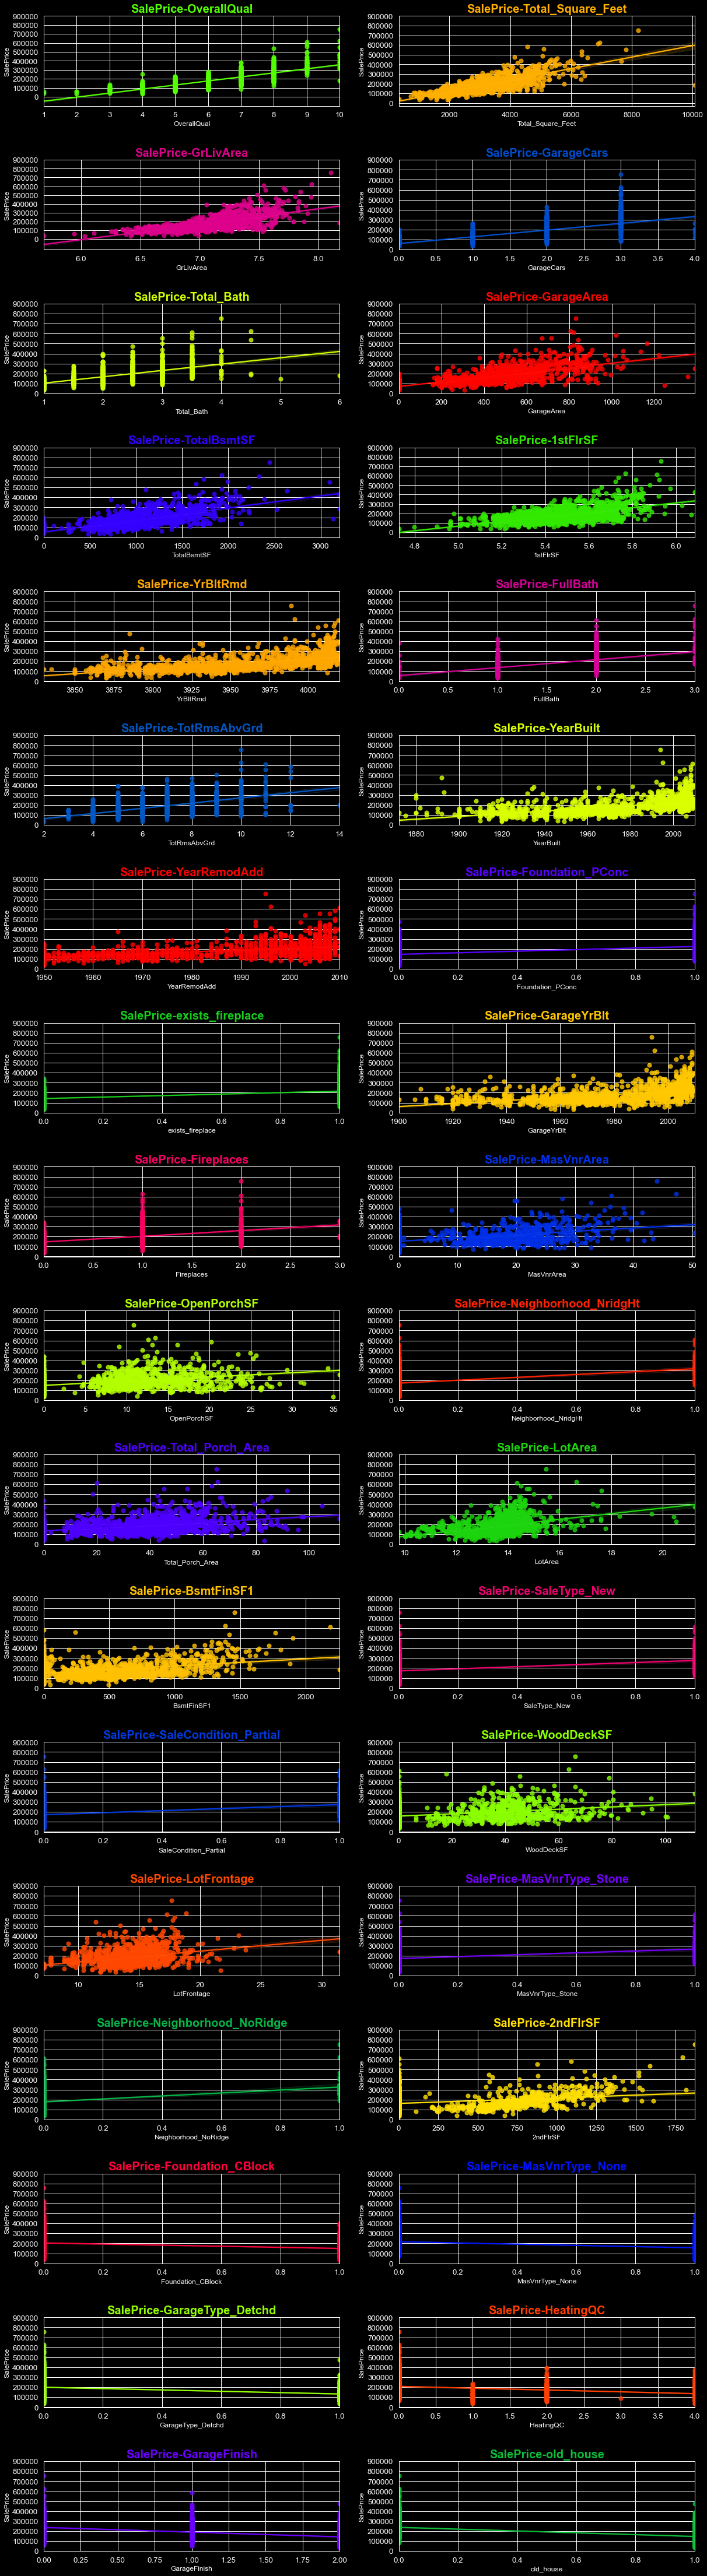

In [39]:
plt.style.use('dark_background')
fig, axes = plt.subplots(18, 2, figsize = (20, 80))
fig.subplots_adjust(hspace = 0.6)
colors = [plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]

for i, ax, color in zip(best_columns, axes.flatten(), colors):
    sb.regplot(x = train[i], y = train['SalePrice'], fit_reg=True, marker = 'o'
               , scatter_kws={'s':50, 'alpha':0.8}, color=color, ax=ax)
    plt.xlabel(i, fontsize = 12)
    plt.ylabel('SalePrice', fontsize = 12)
    ax.set_yticks(np.arange(0, 900001, 100000))
    ax.set_title('SalePrice' + '-' + str(i), color=color, fontweight = 'bold', size = 20)

<AxesSubplot:xlabel='OverallQual', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'OverallQual')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - OverallQual')

<AxesSubplot:xlabel='Total_Square_Feet', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Total_Square_Feet')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Total_Square_Feet')

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GrLivArea')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GrLivArea')

<AxesSubplot:xlabel='GarageCars', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GarageCars')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GarageCars')

<AxesSubplot:xlabel='Total_Bath', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Total_Bath')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Total_Bath')

<AxesSubplot:xlabel='GarageArea', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GarageArea')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GarageArea')

<AxesSubplot:xlabel='TotalBsmtSF', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'TotalBsmtSF')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - TotalBsmtSF')

<AxesSubplot:xlabel='1stFlrSF', ylabel='SalePrice_Log1p'>

Text(0.5, 0, '1stFlrSF')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - 1stFlrSF')

<AxesSubplot:xlabel='YrBltRmd', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'YrBltRmd')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - YrBltRmd')

<AxesSubplot:xlabel='FullBath', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'FullBath')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - FullBath')

<AxesSubplot:xlabel='TotRmsAbvGrd', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'TotRmsAbvGrd')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - TotRmsAbvGrd')

<AxesSubplot:xlabel='YearBuilt', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'YearBuilt')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - YearBuilt')

<AxesSubplot:xlabel='YearRemodAdd', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'YearRemodAdd')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - YearRemodAdd')

<AxesSubplot:xlabel='Foundation_PConc', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Foundation_PConc')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Foundation_PConc')

<AxesSubplot:xlabel='exists_fireplace', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'exists_fireplace')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - exists_fireplace')

<AxesSubplot:xlabel='GarageYrBlt', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GarageYrBlt')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GarageYrBlt')

<AxesSubplot:xlabel='Fireplaces', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Fireplaces')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Fireplaces')

<AxesSubplot:xlabel='MasVnrArea', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'MasVnrArea')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - MasVnrArea')

<AxesSubplot:xlabel='OpenPorchSF', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'OpenPorchSF')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - OpenPorchSF')

<AxesSubplot:xlabel='Neighborhood_NridgHt', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Neighborhood_NridgHt')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Neighborhood_NridgHt')

<AxesSubplot:xlabel='Total_Porch_Area', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Total_Porch_Area')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Total_Porch_Area')

<AxesSubplot:xlabel='LotArea', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'LotArea')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - LotArea')

<AxesSubplot:xlabel='BsmtFinSF1', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'BsmtFinSF1')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - BsmtFinSF1')

<AxesSubplot:xlabel='SaleType_New', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'SaleType_New')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - SaleType_New')

<AxesSubplot:xlabel='SaleCondition_Partial', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'SaleCondition_Partial')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - SaleCondition_Partial')

<AxesSubplot:xlabel='WoodDeckSF', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'WoodDeckSF')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - WoodDeckSF')

<AxesSubplot:xlabel='LotFrontage', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'LotFrontage')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - LotFrontage')

<AxesSubplot:xlabel='MasVnrType_Stone', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'MasVnrType_Stone')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - MasVnrType_Stone')

<AxesSubplot:xlabel='Neighborhood_NoRidge', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Neighborhood_NoRidge')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Neighborhood_NoRidge')

<AxesSubplot:xlabel='2ndFlrSF', ylabel='SalePrice_Log1p'>

Text(0.5, 0, '2ndFlrSF')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - 2ndFlrSF')

<AxesSubplot:xlabel='Foundation_CBlock', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'Foundation_CBlock')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - Foundation_CBlock')

<AxesSubplot:xlabel='MasVnrType_None', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'MasVnrType_None')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - MasVnrType_None')

<AxesSubplot:xlabel='GarageType_Detchd', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GarageType_Detchd')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GarageType_Detchd')

<AxesSubplot:xlabel='HeatingQC', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'HeatingQC')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - HeatingQC')

<AxesSubplot:xlabel='GarageFinish', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'GarageFinish')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - GarageFinish')

<AxesSubplot:xlabel='old_house', ylabel='SalePrice_Log1p'>

Text(0.5, 0, 'old_house')

Text(0, 0.5, 'SalePrice_Log1p')

Text(0.5, 1.0, 'SalePrice_Log1p - old_house')

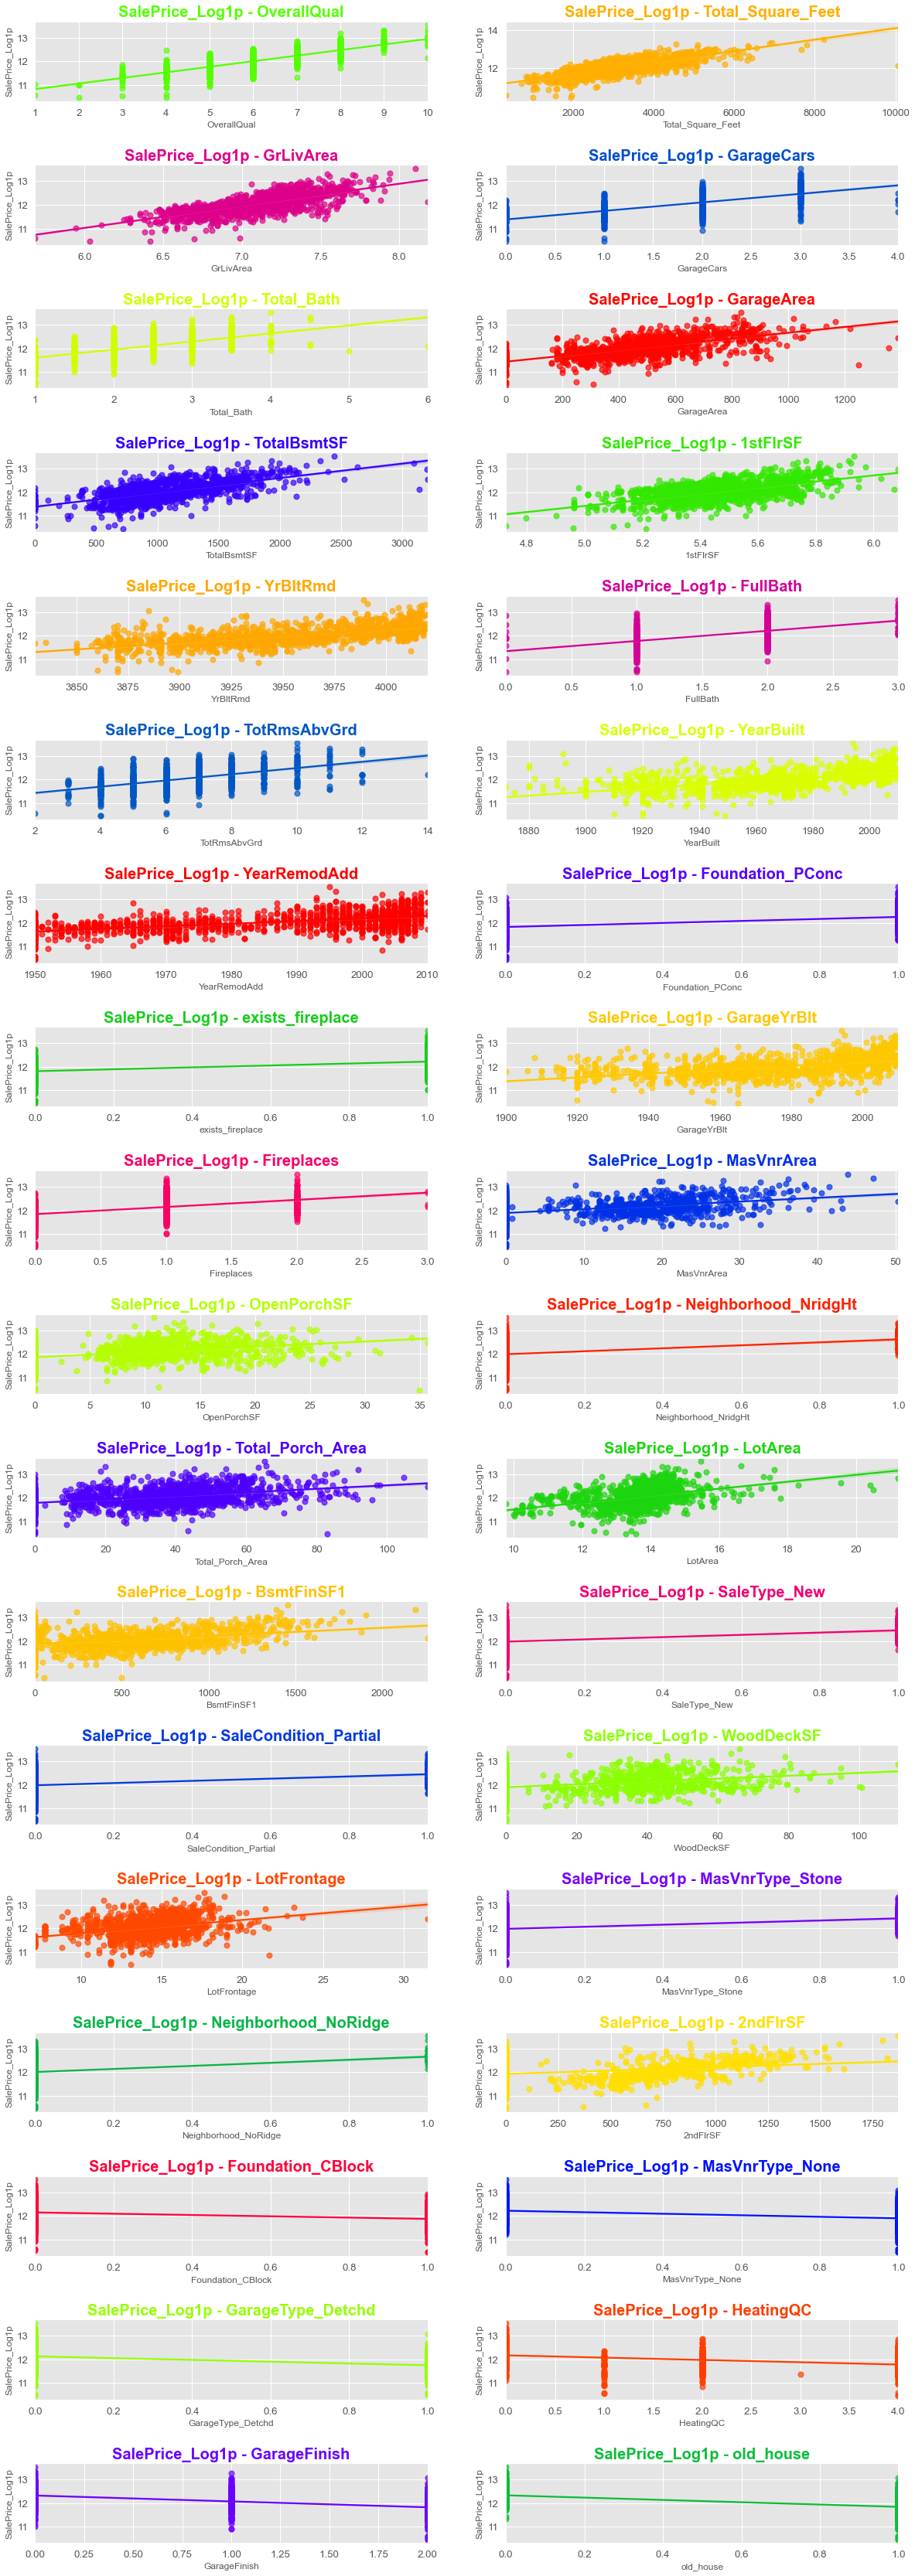

In [40]:
plt.style.use('ggplot')
fig, axes = plt.subplots(18, 2,figsize=(20,60))
fig.subplots_adjust(hspace=0.8)
sb.set(font_scale=1.2)
colors=[plt.cm.prism_r(each) for each in np.linspace(0, 1, len(best_columns))]
for i,ax,color in zip(best_columns,axes.flatten(),colors):
    sb.regplot(x=train[i], y=train["SalePrice_Log1p"], fit_reg=True,marker='o',scatter_kws={'s':50,'alpha':0.7},color=color,ax=ax)
    plt.xlabel(i,fontsize=12)
    plt.ylabel('SalePrice_Log1p',fontsize=12)
    ax.set_title('SalePrice_Log1p'+' - '+str(i),color=color,fontweight='bold',size=20)

In [41]:
train = train[train.GarageArea * train.GarageCars < 3700]
train = train[(train.FullBath + (train.HalfBath*0.5) + train.BsmtFullBath + (train.BsmtHalfBath*0.5))<5]

In [42]:
len(train)

1447

<Figure size 360x1080 with 0 Axes>

<AxesSubplot:>

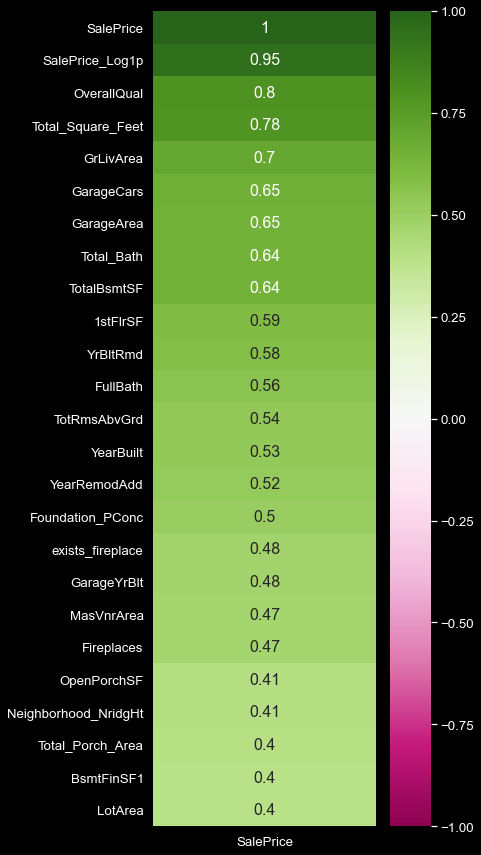

In [43]:
plt.style.use('dark_background')
corr1_new_train = train.corr()
plt.figure(figsize=(5, 15))
sb.heatmap(corr1_new_train[['SalePrice']].sort_values(by = ['SalePrice'], ascending=False).head(25)
           , annot_kws={'size': 16}, vmin = -1, cmap = 'PiYG', annot=True)
sb.set(font_scale = 2)

In [44]:
train.isnull().sum()
test.isnull().sum()

Id                       0
MSSubClass               0
LotFrontage              0
LotArea                  0
Street                   0
Alley                    0
LotShape                 0
LandSlope                0
OverallQual              0
OverallCond              0
YearBuilt                0
YearRemodAdd             0
MasVnrArea               0
ExterQual                0
ExterCond                0
BsmtQual                 0
BsmtCond                 0
BsmtExposure             0
BsmtFinType1             0
BsmtFinSF1               0
BsmtFinType2             0
BsmtFinSF2               0
BsmtUnfSF                0
TotalBsmtSF              0
HeatingQC                0
CentralAir               0
1stFlrSF                 0
2ndFlrSF                 0
LowQualFinSF             0
GrLivArea                0
BsmtFullBath             0
BsmtHalfBath             0
FullBath                 0
HalfBath                 0
BedroomAbvGr             0
KitchenAbvGr             0
KitchenQual              0
T

Id                          0
MSSubClass                  0
LotFrontage                 0
LotArea                     0
Street                      0
Alley                       0
LotShape                    0
LandSlope                   0
OverallQual                 0
OverallCond                 0
YearBuilt                   0
YearRemodAdd                0
MasVnrArea                  0
ExterQual                   0
ExterCond                   0
BsmtQual                    0
BsmtCond                    0
BsmtExposure                0
BsmtFinType1                0
BsmtFinSF1                  0
BsmtFinType2                0
BsmtFinSF2                  0
BsmtUnfSF                   0
TotalBsmtSF                 0
HeatingQC                   0
CentralAir                  0
1stFlrSF                    0
2ndFlrSF                    0
LowQualFinSF                0
GrLivArea                   0
BsmtFullBath                0
BsmtHalfBath                0
FullBath                    0
HalfBath  

In [45]:
del test['SalePrice']

In [46]:
train.head()

Id  MSSubClass  LotFrontage    LotArea    Street  Alley  LotShape  \
0   1           5    13.668864  13.424521  1.965139      1         3   
1   2           0    15.311587  13.694527  1.965139      1         3   
2   3           5    14.011693  14.034133  1.965139      1         0   
3   4           6    13.079140  13.683421  1.965139      1         0   
4   5           5    15.722537  14.550142  1.965139      1         0   

   LandSlope  OverallQual  OverallCond  YearBuilt  YearRemodAdd  MasVnrArea  \
0        0.0            7            4       2003          2003   19.509966   
1        0.0            6            7       1976          1976    0.000000   
2        0.0            7            4       2001          2002   17.835996   
3        0.0            7            4       1915          1970    0.000000   
4        0.0            8            4       2000          2000   25.518156   

   ExterQual  ExterCond   BsmtQual  BsmtCond  BsmtExposure  BsmtFinType1  \
0   5.498765   5.100237  54.556642  5.218987      6.112249             2   
1  11.456357   5.100237  54.556642  5.218987      1.372290             0   
2   5.498765   5.100237  54.556642  5.218987      3.429155             2   
3  11.456357   5.100237  54.556642  1.280547      6.112249             0   
4   5.498765   5.100237  54.556642  5.218987      0.000000             2   

   BsmtFinSF1  BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  HeatingQC  \
0       706.0   1444.255548         0.0      150.0        856.0          0   
1       978.0   1444.255548         0.0      284.0       1262.0          0   
2       486.0   1444.255548         0.0      434.0        920.0          0   
3       216.0   1444.255548         0.0      540.0        756.0          2   
4       655.0   1444.255548         0.0      490.0       1145.0          0   

   CentralAir  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
0   72.932968  5.318378       854           0.0   7.234115           1.0   
1   72.932968  5.550626         0           0.0   6.947212           0.0   
2   72.932968  5.362015       866           0.0   7.275132           1.0   
3   72.932968  5.388291       756           0.0   7.237969           1.0   
4   72.932968  5.493031      1053           0.0   7.470741           1.0   

   BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  KitchenQual  \
0           0.0         2         1             3       0.75096     5.077704   
1           1.0         2         0             3       0.75096    10.302990   
2           0.0         2         1             3       0.75096     5.077704   
3           0.0         1         0             3       0.75096     5.077704   
4           0.0         2         1             4       0.75096     5.077704   

   TotRmsAbvGrd  Functional  Fireplaces  FireplaceQu  GarageYrBlt  \
0             8   30.831053           0            3       2003.0   
1             6   30.831053           1            5       1976.0   
2             6   30.831053           1            5       2001.0   
3             7   30.831053           1            2       1998.0   
4             9   30.831053           1            5       2000.0   

   GarageFinish  GarageCars  GarageArea  GarageQual  GarageCond  PavedDrive  \
0             1         2.0       548.0   23.440981  2952.40927   10.465804   
1             1         2.0       460.0   23.440981  2952.40927   10.465804   
2             1         2.0       608.0   23.440981  2952.40927   10.465804   
3             2         3.0       642.0   23.440981  2952.40927   10.465804   
4             1         3.0       836.0   23.440981  2952.40927   10.465804   

   WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolArea  \
0    0.000000    12.009558       0.000000        0.0          0.0       0.0   
1   56.339208     0.000000       0.000000        0.0          0.0       0.0   
2    0.000000     9.849185       0.000000        0.0          0.0       0.0   
3    0.000000     8.92174

### Modeling

In [47]:
X = train.drop(['SalePrice', 'SalePrice_Log1p', 'Classes'], axis = 1)
y = train.SalePrice_Log1p

In [48]:
def overfit_reducer(df):

    overfit = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if zeros / len(df) * 100 > 99.9:
            overfit.append(i)
    overfit = list(overfit)
    return overfit

overfitted_features = overfit_reducer(X)

X.shape
test.shape

(1447, 231)

(1459, 231)

In [49]:
X.drop(overfitted_features,axis=1,inplace=True)
test.drop(overfitted_features,axis=1,inplace=True)
X.shape
test.shape

(1447, 211)

(1459, 211)

In [50]:
std_scaler = StandardScaler()
rbst_scaler = RobustScaler()
power_transformer = PowerTransformer()
X_std = std_scaler.fit_transform(X)
X_rbst = rbst_scaler.fit_transform(X)
X_pwr = power_transformer.fit_transform(X)

test_std = std_scaler.transform(test)
test_rbst = rbst_scaler.transform(test)
test_pwr = power_transformer.transform(test)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.002, random_state=52)

X_train.shape
X_test.shape
y_train.shape
y_test.shape

(1444, 211)

(3, 211)

(1444,)

(3,)

In [52]:
# LGBM
lgb_regressor=lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.035, n_estimators=2177, max_bin=50
                                , bagging_fraction=0.65,bagging_freq=5, bagging_seed=7
                                , feature_fraction=0.201, feature_fraction_seed=7,n_jobs=-1)

lgb_regressor.fit(X_train, y_train)
y_head=lgb_regressor.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] feature_fraction is set=0.201, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.201
[LightGBM] [Warning] bagging_fraction is set=0.65, subsample=1.0 will be ignored. Current value: bagging_fraction=0.65


LGBMRegressor(bagging_fraction=0.65, bagging_freq=5, bagging_seed=7,
              feature_fraction=0.201, feature_fraction_seed=7,
              learning_rate=0.035, max_bin=50, n_estimators=2177, num_leaves=5,
              objective='regression')

R square Accuracy:  -0.2152661223097585
Mean Absolute Error Accuracy:  0.17421869873677842
Mean Squared Error Accuracy:  0.034164821227386746


In [53]:
# GBR
gb_reg = GradientBoostingRegressor(n_estimators=1992, learning_rate=0.03005, max_depth=4, max_features='sqrt'
                                   , min_samples_leaf=15, min_samples_split=14, loss='huber', random_state=42)
gb_reg.fit(X_train, y_train)
y_head = gb_reg.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

GradientBoostingRegressor(learning_rate=0.03005, loss='huber', max_depth=4,
                          max_features='sqrt', min_samples_leaf=15,
                          min_samples_split=14, n_estimators=1992,
                          random_state=42)

R square Accuracy:  -1.2450465271876312
Mean Absolute Error Accuracy:  0.20220328456272854
Mean Squared Error Accuracy:  0.06311507565334767


In [54]:
# RidgeCV
kfolds = KFold(n_splits=10, shuffle=True, random_state=42)

alphas = [1e-9,1e-8,1e-7,1e-6]

ridgecv_reg = make_pipeline(RidgeCV(alphas, cv = kfolds))
ridgecv_reg.fit(X_train, y_train)
y_head = ridgecv_reg.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

Pipeline(steps=[('ridgecv',
                 RidgeCV(alphas=array([1.e-09, 1.e-08, 1.e-07, 1.e-06]),
                         cv=KFold(n_splits=10, random_state=42, shuffle=True)))])

R square Accuracy:  -0.6957187999683812
Mean Absolute Error Accuracy:  0.17012291342807848
Mean Squared Error Accuracy:  0.0476718050386595


In [55]:
# LassoCV
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

lassocv_reg = make_pipeline(LassoCV(alphas=alphas, cv = kfolds))
lassocv_reg.fit(X_train, y_train)
y_head = lassocv_reg.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

Pipeline(steps=[('lassocv',
                 LassoCV(alphas=[1e-09, 1e-08, 1e-07, 1e-06],
                         cv=KFold(n_splits=8, random_state=42, shuffle=True)))])

R square Accuracy:  -0.7095720738044269
Mean Absolute Error Accuracy:  0.17104987291021226
Mean Squared Error Accuracy:  0.04806126263591645


In [56]:
# ElasticNetCV
kfolds = KFold(n_splits=8, shuffle=True, random_state=42)

alphas = [0.0001, 0.0002, 0.0003, 0.0004, 0.0005, 0.0006]
l1ratio=[0.87, 0.9,0.92, 0.95,0.97, 0.99, 1]

elasticv_reg = make_pipeline(ElasticNetCV(alphas=alphas, cv = kfolds, l1_ratio=l1ratio))
elasticv_reg.fit(X_train, y_train)
y_head = elasticv_reg.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

Pipeline(steps=[('elasticnetcv',
                 ElasticNetCV(alphas=[0.0001, 0.0002, 0.0003, 0.0004, 0.0005,
                                      0.0006],
                              cv=KFold(n_splits=8, random_state=42, shuffle=True),
                              l1_ratio=[0.87, 0.9, 0.92, 0.95, 0.97, 0.99,
                                        1]))])

R square Accuracy:  -0.9895134601564872
Mean Absolute Error Accuracy:  0.19220747400260643
Mean Squared Error Accuracy:  0.055931265134370974


In [57]:
# StackingRegressor
estimators = [('lgbm', lgb_regressor), ('gbr', gb_reg), ('lasso', lassocv_reg)
              , ('ridge', ridgecv_reg), ('elasticent', elasticv_reg)]

stack_reg = StackingRegressor(estimators=estimators, final_estimator=ExtraTreesRegressor(n_estimators=50), n_jobs=-1)
stack_reg.fit(X_train, y_train)
y_head = stack_reg.predict(X_test)

print('R square Accuracy: ',r2_score(y_test,y_head))
print('Mean Absolute Error Accuracy: ',mean_absolute_error(y_test,y_head))
print('Mean Squared Error Accuracy: ',mean_squared_error(y_test,y_head))

StackingRegressor(estimators=[('lgbm',
                               LGBMRegressor(bagging_fraction=0.65,
                                             bagging_freq=5, bagging_seed=7,
                                             feature_fraction=0.201,
                                             feature_fraction_seed=7,
                                             learning_rate=0.035, max_bin=50,
                                             n_estimators=2177, num_leaves=5,
                                             objective='regression')),
                              ('gbr',
                               GradientBoostingRegressor(learning_rate=0.03005,
                                                         loss='huber',
                                                         max_depth=4,
                                                         max_features='sqrt',
                                                         min_samples_...
                                        

R square Accuracy:  -0.12688047804852487
Mean Absolute Error Accuracy:  0.15902278426022498
Mean Squared Error Accuracy:  0.0316800323570172


In [58]:
y_head = pd.DataFrame(y_head, columns=['Predict'])
y_test.reset_index(drop = True, inplace = True)
y_test_y_head = pd.concat([y_test, y_head], axis = 1)
y_test_y_head.head()

SalePrice_Log1p    Predict
0        12.072547  12.187494
1        11.767575  12.038806
2        11.681832  11.590942

In [59]:
len(test.columns)
len(X.columns)

211

211

In [60]:
# Predict
test_pred_lgb = lgb_regressor.predict(test_pwr)
test_pred_gb=gb_reg.predict(test_pwr)
test_pred_elastic=elasticv_reg.predict(test_pwr)
test_pred_ridge=ridgecv_reg.predict(test_pwr)
test_pred_lasso=lassocv_reg.predict(test_pwr)
test_pred_stack=stack_reg.predict(test_pwr)

In [61]:
# to DataFrame
test_pred_lgb=pd.DataFrame(test_pred_lgb,columns=['SalePrice'])
test_pred_gb=pd.DataFrame(test_pred_gb,columns=['SalePrice'])
test_pred_elastic=pd.DataFrame(test_pred_elastic,columns=['SalePrice'])
test_pred_ridge=pd.DataFrame(test_pred_ridge,columns=['SalePrice'])
test_pred_lasso=pd.DataFrame(test_pred_lasso,columns=['SalePrice'])
test_pred_stack=pd.DataFrame(test_pred_stack,columns=['SalePrice'])

In [62]:
test_pred_lgb.SalePrice =np.floor(np.expm1(test_pred_lgb.SalePrice))
test_pred_gb.SalePrice =np.floor(np.expm1(test_pred_gb.SalePrice))
test_pred_elastic.SalePrice =np.floor(np.expm1(test_pred_elastic.SalePrice))
test_pred_ridge.SalePrice =np.floor(np.expm1(test_pred_ridge.SalePrice))
test_pred_lasso.SalePrice =np.floor(np.expm1(test_pred_lasso.SalePrice))
test_pred_stack.SalePrice =np.floor(np.expm1(test_pred_stack.SalePrice))

In [63]:
test_pred_lgb.head()
test_pred_gb.head()
test_pred_elastic.head()
test_pred_ridge.head()
test_pred_lasso.head()
test_pred_stack.head()

SalePrice
0   121746.0
1   164397.0
2   183707.0
3   203040.0
4   184621.0

SalePrice
0   131308.0
1   161539.0
2   194631.0
3   203451.0
4   185432.0

SalePrice
0   123191.0
1   159267.0
2   185635.0
3   203467.0
4   208882.0

SalePrice
0   133642.0
1   154911.0
2   187043.0
3   206864.0
4   213891.0

SalePrice
0   140100.0
1   154437.0
2   186955.0
3   211123.0
4   218294.0

SalePrice
0   124871.0
1   147242.0
2   195903.0
3   204191.0
4   196216.0

In [64]:
# final predict
final_pred=(test_pred_stack*0.1665)+(test_pred_lgb*0.678)+(test_pred_ridge*0.1665)
final_pred.head()

SalePrice
0  125586.2025
1  161769.6405
2  188313.8550
3  206101.7775
4  193455.8535

In [65]:
sample['SalePrice'] = final_pred

sample.head()

Id    SalePrice
0  1461  125586.2025
1  1462  161769.6405
2  1463  188313.8550
3  1464  206101.7775
4  1465  193455.8535

In [66]:
# to csv
# sample_sub.to_csv('House_Price.csv',index=False)